# **Video Link**
https://drive.google.com/drive/folders/1ejDNJLF_XjhNJtalqX4jyfH4wpgEpkoE?usp=sharing

# **Denoising Autoencoder Introduction**

## ***Autoencoder***

> Source: [Autoencoders in Machine Learning](https://www.geeksforgeeks.org/machine-learning/auto-encoders/)

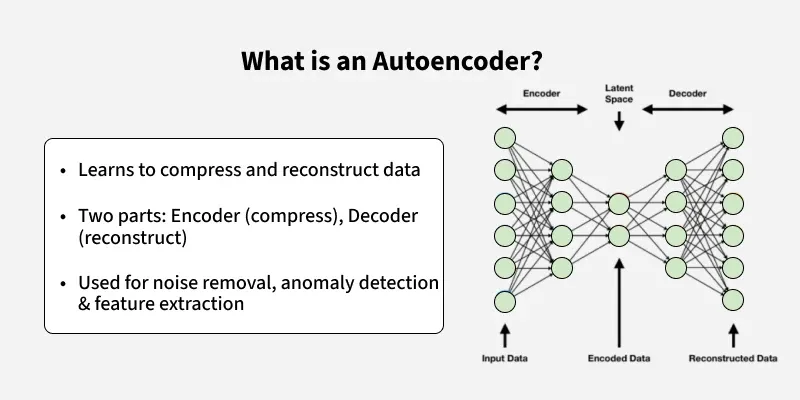

**Autoencoders** are a type of neural network used to compress and reconstruct data. They have two main parts:
1. **Encoder**: compresses the input into a smaller (lower-dimensional) version.
2. **Decoder**: tries to rebuild the original input from that smaller version.

The goal is to minimize the difference between the input and the output. But if not designed carefully, the model might just copy the input (acting like an identity function), which doesn’t teach it anything useful. It's a type of artificial neural network used to learn efficient representations of input data, typically for dimensionality reduction, denoising, or feature learning. It works in an unsupervised learning setup, meaning it doesn’t need labeled data.



## ***Denoising Autoencoder (DAE)***

A DAE is an improved version of an autoencoder. Instead of giving the clean input to the model, we give it a **noisy version and train it to reconstruct the clean version**. This makes the model learn more useful patterns and reduces the risk of just copying the input.

**How it works:**
1. We add noise to the input (like random pixels or Gaussian noise).
2. The encoder gets this noisy input and compresses it.
3. The decoder tries to rebuild the original (clean) input.
4. We calculate the loss between the clean input and the reconstructed output.

**Why use DAE?**
  * Helps the model learn to fix or clean data.
  * Can be useful for image denoising, filling missing values, or working with noisy data.
  * Makes the model more robust and generalizable.

## ***DAE Architecture***

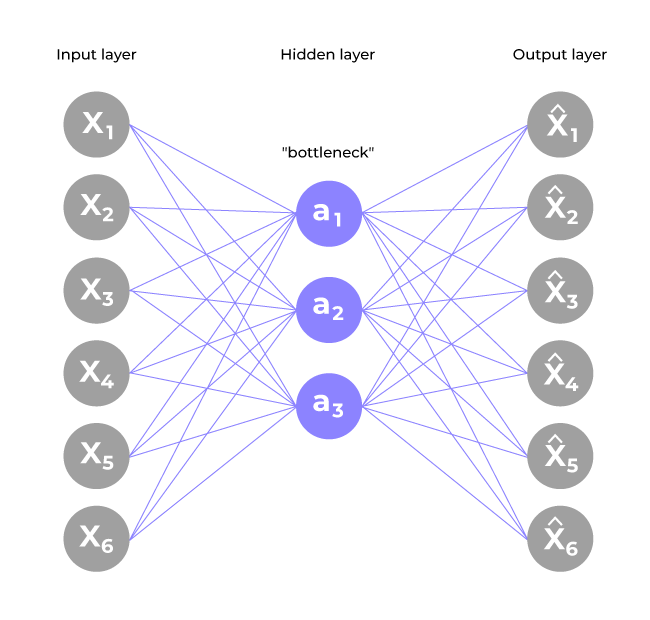

Source: [Denoising AutoEncoders In Machine Learning](https://www.geeksforgeeks.org/machine-learning/denoising-autoencoders-in-machine-learning/)

A **Denoising Autoencoder** shares the same structural design as a standard autoencoder but is specifically trained to reconstruct **clean inputs from noisy versions**. This makes it effective in learning robust representations and eliminating noise. The architecture consists of three main components:

---

**1. Encoder**

The **encoder** in a DAE receives a **corrupted (noisy)** version of the input and compresses it into a lower-dimensional latent space while attempting to retain essential features.

* **Input Layer**:
  Instead of the original clean input, this layer receives a noisy version of the data. The noise can be added through techniques such as **Gaussian noise**, **salt-and-pepper noise**, or **random masking** to simulate real-world corruption.

* **Hidden Layers**:
  These layers apply non-linear transformations to extract key patterns that are robust to noise. The encoder progressively filters out noise and compresses the input into a meaningful summary.

* **Output (Latent Space)**:
  The final output of the encoder is the **latent representation**, a compact vector that captures the core structure of the input even when the data is partially corrupted.

---

**2. Bottleneck (Latent Space)**

Just like in a standard autoencoder, the **bottleneck** is the central part of the architecture where the most **compressed and abstract representation** of the input resides.

* This layer is crucial because it **forces the model to focus on the most informative aspects** of the input, helping it ignore irrelevant noise.
* It ensures that only the most significant features are passed to the decoder, enabling **better generalization** and robustness.

---

**3. Decoder**

The **decoder** takes the compressed latent representation and attempts to reconstruct the **original clean data**, not the noisy input. This teaches the model how to correct corrupted information.

* **Hidden Layers**:
  These layers gradually **expand** the latent vector back to the original input shape. They apply learned transformations to reverse the compression process.

* **Output Layer**:
  This layer generates the final reconstructed output, which should ideally be as close as possible to the original (clean) input.
  During training, the model compares this output to the **clean input** and uses a loss function, commonly **Mean Squared Error (MSE)** to minimize the reconstruction error.

---

**Summary**

The key innovation in Denoising Autoencoders is the training on **noisy inputs with clean targets**. This setup encourages the network to **learn robust features** and develop an internal understanding of the data structure, making it effective for **noise removal**, **image and audio restoration**, and **pretraining for deep models**.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.9 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import zipfile
import matplotlib.image as mpimg
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Activation, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras_tuner import GridSearch
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
zzip_file_path = '/content/drive/MyDrive/Deep Learning/A_23.zip'

extract_base_path = '/content/dataset/'

with zipfile.ZipFile(zzip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_base_path)

print(f"File directory: {extract_base_path}: {os.listdir(extract_base_path)}")

File directory: /content/dataset/: ['A_23']


In [56]:
data_folder = os.path.join(extract_base_path, 'A_23')

image_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
images = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
images = np.array(images)

print(f"Total images: {len(images)}")
if len(images) > 0:
    print(f"First image dimension (example): {images[0].shape}")
else:
    print("No image found!")

Total images: 1074
First image dimension (example): (600, 600, 3)


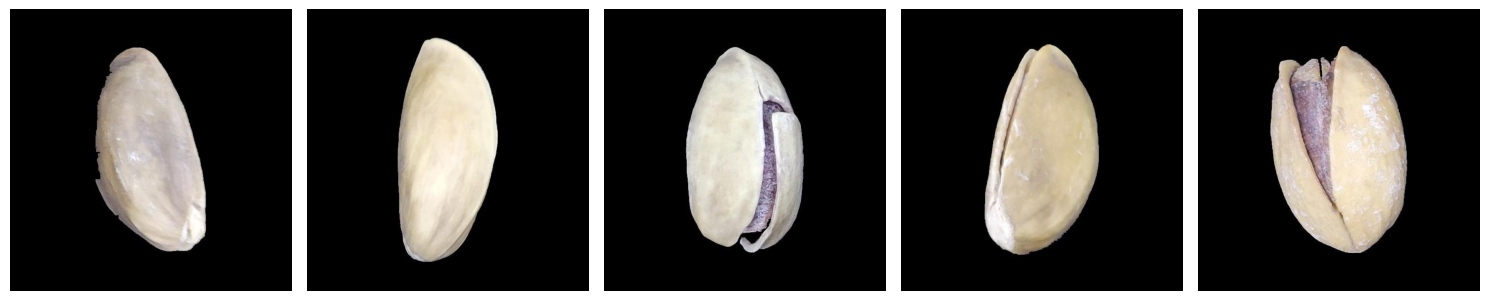

In [57]:
n_samples = 5

plt.figure(figsize=(15, 10))
random_images_sample = random.sample(list(images), min(n_samples, len(images)))

for i, img_array in enumerate(random_images_sample):
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(img_array)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [58]:
def check_corrupted_files(directory):
    corrupted = []
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for filename in image_files:
        img_path = os.path.join(directory, filename)
        try:
            with Image.open(img_path) as img:
                img.verify()
        except:
            corrupted.append(img_path)
    return corrupted

IMAGE_DIR = data_folder

corrupted_images = check_corrupted_files(IMAGE_DIR)

print(f"Found {len(corrupted_images)} corrupted images:")
for path in corrupted_images:
    print(" -", path)

Found 0 corrupted images:


# **Exploratory Data Analysis**

## ***Unique Data Types***

In [8]:
def get_image_data_types(directory):
    image_data_types = []

    for image_name in os.listdir(directory):
        if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        image_path = os.path.join(directory, image_name)
        try:
            img = Image.open(image_path)
            img_array = np.array(img)
            image_data_types.append(img_array.dtype)
        except Exception as e:
            print(f"Error processing {image_name}: {e}")

    return set(image_data_types)

IMAGE_DIR = data_folder
image_data_types = get_image_data_types(IMAGE_DIR)
print("Image data types in the folder:", image_data_types)

Image data types in the folder: {dtype('uint8')}


All images in the folder use the **uint8** data type, meaning their pixel values range from 0 to 255, typical for standard RGB images.


## ***Unique File Types***

In [10]:
from collections import Counter
def show_unique_file_types(directory):
    file_type_counter = Counter()

    for filename in os.listdir(directory):
        if '.' in filename:
            ext = os.path.splitext(filename)[1].lower()
            file_type_counter[ext] += 1

    if file_type_counter:
        print("File types found in the folder:")
        for file_type, count in file_type_counter.items():
            print(f"  '{file_type}': {count} file(s)")
    else:
        print("No files with extensions found.")
IMAGE_DIR = data_folder
show_unique_file_types(IMAGE_DIR)

File types found in the folder:
  '.jpg': 1074 file(s)


The folder contains **1074 `.jpg` files**, indicating all images are in JPEG format.

## ***RGB Distribution***

Total images analyzed: 1074
Grayscale: 0
RGB: 1074


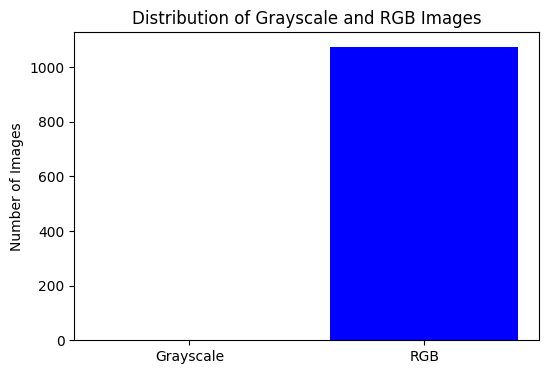

In [11]:
def display_image_type_distribution_simple(image_dir):
    grayscale_count = 0
    rgb_count = 0

    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    for img_file in image_files:
        image_path = os.path.join(image_dir, img_file)
        img = mpimg.imread(image_path)

        if len(img.shape) == 2:
            grayscale_count += 1
        elif len(img.shape) == 3 and img.shape[2] == 3:
            rgb_count += 1

    print(f"Total images analyzed: {len(image_files)}")
    print(f"Grayscale: {grayscale_count}")
    print(f"RGB: {rgb_count}")

    plt.figure(figsize=(6, 4))
    plt.bar(['Grayscale', 'RGB'], [grayscale_count, rgb_count], color=['gray', 'blue'])
    plt.title('Distribution of Grayscale and RGB Images')
    plt.ylabel('Number of Images')
    plt.show()
display_image_type_distribution_simple(data_folder)

All **1074 images** in the folder are in **RGB format**, with **no grayscale images** present.

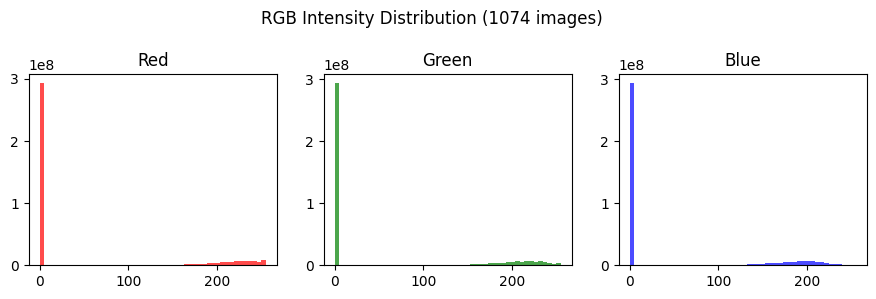


-- Avg Red per Image --
Overall Mean: 50.96
Median: 50.90
Std Dev: 8.04
Min: 22.21
Max: 75.41

-- Avg Green per Image --
Overall Mean: 48.18
Median: 48.28
Std Dev: 7.65
Min: 20.71
Max: 71.29

-- Avg Blue per Image --
Overall Mean: 44.31
Median: 44.48
Std Dev: 6.97
Min: 19.80
Max: 69.04


In [12]:
def display_avg_rgb_histogram(image_dir, n_images=10, img_size=(224, 224)):
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    selected_images = random.sample(image_files, min(n_images, len(image_files)))

    per_image_r_means = []
    per_image_g_means = []
    per_image_b_means = []

    for img_file in selected_images:
        image_path = os.path.join(image_dir, img_file)
        img = mpimg.imread(image_path)

        if len(img.shape) != 3 or img.shape[2] != 3:
            continue

        if img.dtype == np.float32 or img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)

        if img.shape[:2] != img_size:
            img = Image.fromarray(img).resize(img_size)
            img = np.array(img)

        r = img[:, :, 0]
        g = img[:, :, 1]
        b = img[:, :, 2]

        per_image_r_means.append(np.mean(r))
        per_image_g_means.append(np.mean(g))
        per_image_b_means.append(np.mean(b))

    if not per_image_r_means:
        print("No RGB images found in the selected sample.")
        return

    all_r = np.concatenate([img[:, :, 0].flatten() for img_file in selected_images
                            if (img := mpimg.imread(os.path.join(image_dir, img_file))).ndim == 3 and img.shape[2] == 3])
    all_g = np.concatenate([img[:, :, 1].flatten() for img_file in selected_images
                            if (img := mpimg.imread(os.path.join(image_dir, img_file))).ndim == 3 and img.shape[2] == 3])
    all_b = np.concatenate([img[:, :, 2].flatten() for img_file in selected_images
                            if (img := mpimg.imread(os.path.join(image_dir, img_file))).ndim == 3 and img.shape[2] == 3])

    plt.figure(figsize=(9, 3))
    plt.suptitle("RGB Intensity Distribution ({} images)".format(len(per_image_r_means)))

    plt.subplot(1, 3, 1)
    plt.hist(all_r, bins=50, color='red', alpha=0.7)
    plt.title("Red")

    plt.subplot(1, 3, 2)
    plt.hist(all_g, bins=50, color='green', alpha=0.7)
    plt.title("Green")

    plt.subplot(1, 3, 3)
    plt.hist(all_b, bins=50, color='blue', alpha=0.7)
    plt.title("Blue")

    plt.tight_layout()
    plt.show()

    def print_stats(channel_name, values):
        print(f"\n-- Avg {channel_name} per Image --")
        print(f"Overall Mean: {np.mean(values):.2f}")
        print(f"Median: {np.median(values):.2f}")
        print(f"Std Dev: {np.std(values):.2f}")
        print(f"Min: {np.min(values):.2f}")
        print(f"Max: {np.max(values):.2f}")

    print_stats("Red", per_image_r_means)
    print_stats("Green", per_image_g_means)
    print_stats("Blue", per_image_b_means)
display_avg_rgb_histogram(data_folder, n_images=1074)

The RGB intensity analysis of all 1074 images shows that on average, the **red channel has the highest brightness** (mean ≈ 51), followed by green (≈ 48), and blue (≈ 44), suggesting a slightly warmer tone overall. Each channel also has a relatively narrow spread (standard deviations under 8), indicating consistency in lighting and color tone across the dataset. The minimum and maximum values confirm that while there’s some variation, no extreme brightness or darkness dominates, making the dataset fairly balanced in terms of color distribution.

## ***Saturation***

Analyzing saturation for 1074 images in '/content/dataset/A_23'...


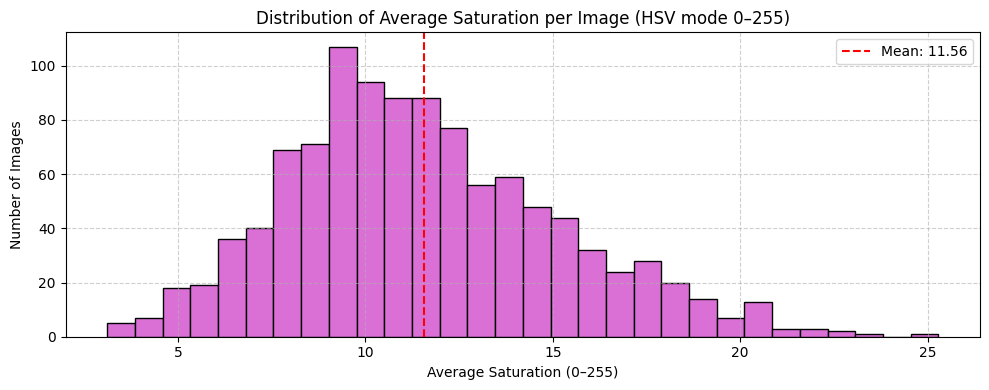


-- Avg Saturation per Image (Pillow HSV 0–255) --
Overall Mean: 11.56
Median: 11.07
Std Dev: 3.65
Min: 3.11
Max: 25.29


In [13]:
def analyze_saturation_distribution(folder_path, n_images=20, resize_to=(224, 224)):
    if not os.path.isdir(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return

    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]
    selected_images = image_files[:min(n_images, len(image_files))]

    avg_saturations = []

    print(f"Analyzing saturation for {len(selected_images)} images in '{folder_path}'...")

    for filename in selected_images:
        image_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(image_path).convert('RGB')
            if resize_to:
                img = img.resize(resize_to)
            hsv_img = img.convert('HSV')
            hsv_array = np.array(hsv_img)

            saturation_channel = hsv_array[:, :, 1]  # S channel
            avg_saturations.append(np.mean(saturation_channel))

        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not avg_saturations:
        print("No valid RGB images processed.")
        return

    plt.figure(figsize=(10, 4))
    plt.hist(avg_saturations, bins=30, color='orchid', edgecolor='black')
    plt.title("Distribution of Average Saturation per Image (HSV mode 0–255)")
    plt.xlabel("Average Saturation (0–255)")
    plt.ylabel("Number of Images")
    plt.axvline(np.mean(avg_saturations), color='red', linestyle='--', label=f"Mean: {np.mean(avg_saturations):.2f}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    print("\n-- Avg Saturation per Image (Pillow HSV 0–255) --")
    print(f"Overall Mean: {np.mean(avg_saturations):.2f}")
    print(f"Median: {np.median(avg_saturations):.2f}")
    print(f"Std Dev: {np.std(avg_saturations):.2f}")
    print(f"Min: {np.min(avg_saturations):.2f}")
    print(f"Max: {np.max(avg_saturations):.2f}")
analyze_saturation_distribution(data_folder, n_images=1074)

The average saturation levels across all 1,074 images are quite low, with a mean of **11.56** on a 0-255 scale. This suggests that the images are mostly desaturated or have muted colors. The small standard deviation (**3.65**) and tight range (min **3.11**, max **25.29**) confirm that this low saturation is consistent throughout the dataset. Overall, the dataset leans heavily toward grayscale or pastel-like tones rather than vivid or colorful images.


## ***Sharpness***

Analyzing sharpness for 1074 images in '/content/dataset/A_23'...


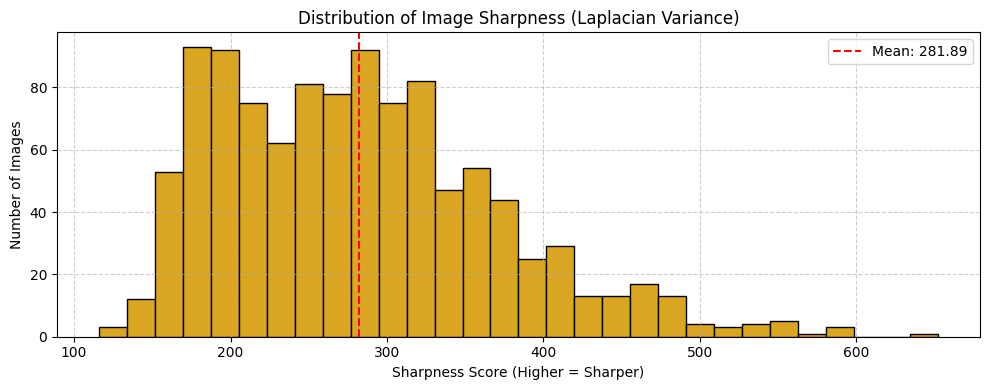


-- Sharpness (Laplacian Variance) per Image --
Overall Mean: 281.89
Median: 275.09
Std Dev: 87.97
Min: 115.87
Max: 652.21
Potentially blurry images (score < 100): 0 out of 1074


In [14]:
def analyze_sharpness_distribution(folder_path, n_images=20, resize_to=(224, 224)):
    if not os.path.isdir(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return

    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]
    selected_images = image_files[:min(n_images, len(image_files))]

    sharpness_scores = []

    print(f"Analyzing sharpness for {len(selected_images)} images in '{folder_path}'...")

    for filename in selected_images:
        image_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(image_path).convert('L')  # convert to grayscale
            if resize_to:
                img = img.resize(resize_to)
            img_np = np.array(img)

            # calculate variance of Laplacian (sharpness measure)
            laplacian = cv2.Laplacian(img_np, cv2.CV_64F)
            sharpness = laplacian.var()
            sharpness_scores.append(sharpness)

        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not sharpness_scores:
        print("No valid images processed.")
        return

    plt.figure(figsize=(10, 4))
    plt.hist(sharpness_scores, bins=30, color='goldenrod', edgecolor='black')
    plt.title("Distribution of Image Sharpness (Laplacian Variance)")
    plt.xlabel("Sharpness Score (Higher = Sharper)")
    plt.ylabel("Number of Images")
    plt.axvline(np.mean(sharpness_scores), color='red', linestyle='--', label=f"Mean: {np.mean(sharpness_scores):.2f}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    print("\n-- Sharpness (Laplacian Variance) per Image --")
    print(f"Overall Mean: {np.mean(sharpness_scores):.2f}")
    print(f"Median: {np.median(sharpness_scores):.2f}")
    print(f"Std Dev: {np.std(sharpness_scores):.2f}")
    print(f"Min: {np.min(sharpness_scores):.2f}")
    print(f"Max: {np.max(sharpness_scores):.2f}")

    threshold = 100  # You can tune this
    blurry_count = sum(score < threshold for score in sharpness_scores)
    print(f"Potentially blurry images (score < {threshold}): {blurry_count} out of {len(sharpness_scores)}")
analyze_sharpness_distribution(data_folder, n_images=1074)

The overall image sharpness in the dataset is quite good, with a mean Laplacian variance of **281.89**, indicating a decent level of edge detail and clarity. The values range from **115.87** to **652.21**, with a median of **275.09**, showing that most images fall within a reasonably sharp range. The standard deviation of **87.97** reflects some variation in sharpness, but it's not extreme. Importantly, **none of the 1,074 images** fell below the commonly used blur threshold of 100, suggesting that the dataset contains **no noticeably blurry images** and is visually sharp overall.

## ***Brightness***

Analyzing image brightness in '/content/dataset/A_23'...


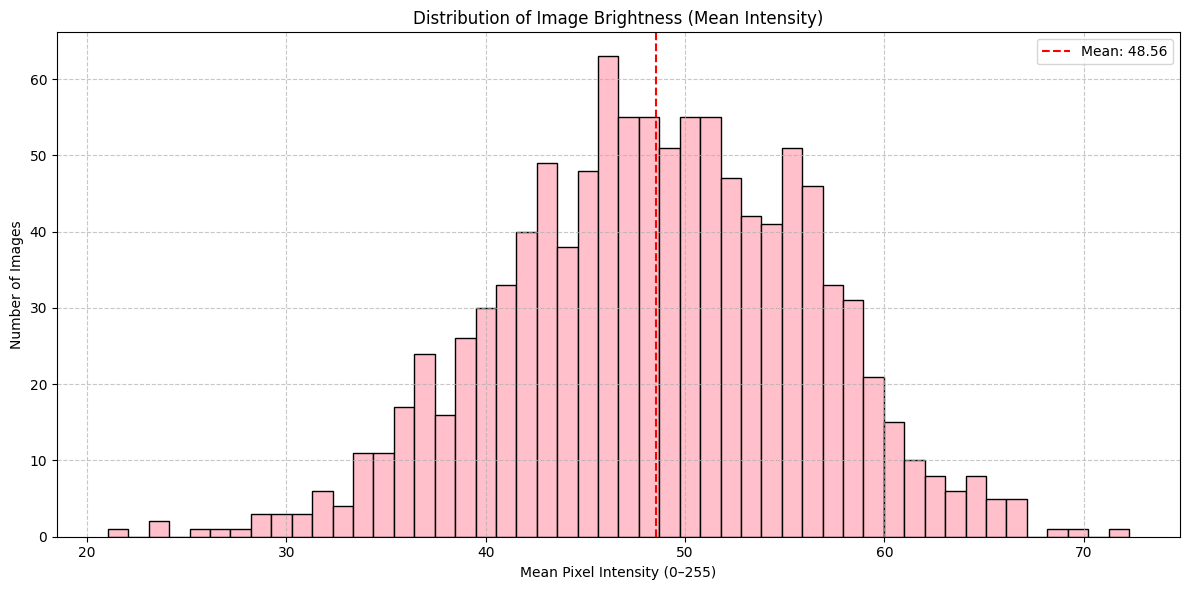


--- Brightness Stats ---
Mean: 48.56
Median: 48.60
Std Dev: 7.65
Min: 21.05
Max: 72.27


In [17]:
def analyze_brightness_distribution(folder_path):
    if not os.path.isdir(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return

    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    mean_intensities = []

    print(f"Analyzing image brightness in '{folder_path}'...")
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(image_path).convert('L')
                arr = np.array(img)
                mean_intensities.append(np.mean(arr))
            except Exception as e:
                print(f"Error reading {filename}: {e}")

    if not mean_intensities:
        print("No valid images processed.")
        return

    plt.figure(figsize=(12, 6))
    plt.hist(mean_intensities, bins=50, color='pink', edgecolor='black')
    plt.title('Distribution of Image Brightness (Mean Intensity)')
    plt.xlabel('Mean Pixel Intensity (0–255)')
    plt.ylabel('Number of Images')
    plt.axvline(np.mean(mean_intensities), color='red', linestyle='dashed', label=f'Mean: {np.mean(mean_intensities):.2f}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\n--- Brightness Stats ---")
    print(f"Mean: {np.mean(mean_intensities):.2f}")
    print(f"Median: {np.median(mean_intensities):.2f}")
    print(f"Std Dev: {np.std(mean_intensities):.2f}")
    print(f"Min: {np.min(mean_intensities):.2f}")
    print(f"Max: {np.max(mean_intensities):.2f}")
analyze_brightness_distribution(data_folder)

The brightness levels of the images in the dataset are fairly consistent, with a **mean pixel intensity of 48.56** and a **median of 48.60**, suggesting that most images are moderately dark or neutral in tone (on a 0-255 scale). The **standard deviation of 7.65** indicates a modest spread in brightness across images. The **minimum brightness** recorded is **21.05**, while the **maximum is 72.27**, meaning there are no extremely dark or overly bright images. Overall, the dataset appears to have well-balanced brightness with no major outliers.

## ***Contrast***

Analyzing image contrast in '/content/dataset/A_23'...


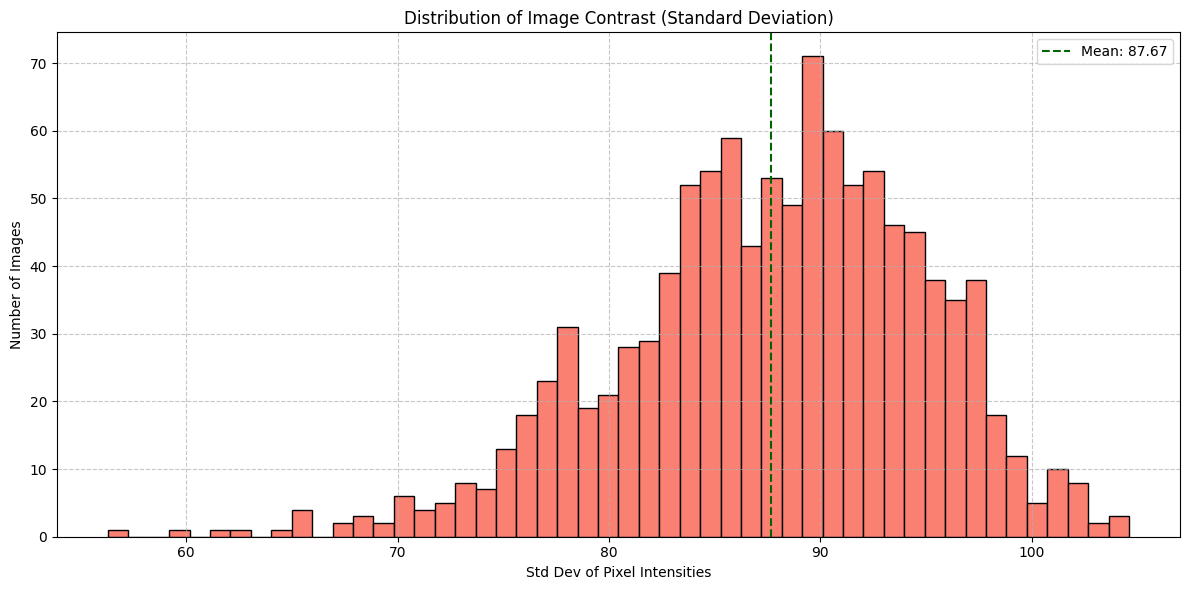


--- Contrast Stats ---
Mean: 87.67
Median: 88.39
Std Dev: 7.27
Min: 56.30
Max: 104.61


In [18]:
def analyze_contrast_distribution(folder_path):
    if not os.path.isdir(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return

    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    std_devs = []

    print(f"Analyzing image contrast in '{folder_path}'...")
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(image_path).convert('L')
                arr = np.array(img)
                std_devs.append(np.std(arr))
            except Exception as e:
                print(f"Error reading {filename}: {e}")

    if not std_devs:
        print("No valid images processed.")
        return

    plt.figure(figsize=(12, 6))
    plt.hist(std_devs, bins=50, color='salmon', edgecolor='black')
    plt.title('Distribution of Image Contrast (Standard Deviation)')
    plt.xlabel('Std Dev of Pixel Intensities')
    plt.ylabel('Number of Images')
    plt.axvline(np.mean(std_devs), color='darkgreen', linestyle='dashed', label=f'Mean: {np.mean(std_devs):.2f}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\n--- Contrast Stats ---")
    print(f"Mean: {np.mean(std_devs):.2f}")
    print(f"Median: {np.median(std_devs):.2f}")
    print(f"Std Dev: {np.std(std_devs):.2f}")
    print(f"Min: {np.min(std_devs):.2f}")
    print(f"Max: {np.max(std_devs):.2f}")
analyze_contrast_distribution(data_folder)

The contrast analysis shows that most images in the dataset have **moderate to high contrast**, with a **mean standard deviation of 87.67** and a **median of 88.39**, indicating that pixel intensities vary well enough to create clear visual differences. The **standard deviation of contrast values is 7.27**, showing some diversity across the dataset. The **lowest contrast value is 56.30**, and the **highest is 104.61**, suggesting that while a few images are relatively flat in tone, the majority maintain strong contrast, which is generally beneficial for tasks like object recognition or segmentation.


## ***Angle***


Estimated Orientation Angles (degrees):
[150.3, 177.44, 105.2, 7.64, 169.46, 169.99, 2.37, 9.95, 179.18, 2.23, 58.63, 103.19, 83.46, 173.46, 160.91, 2.1, 169.5, 9.2, 175.25, 173.55, 2.37, 2.91, 162.42, 162.02, 6.66, 11.38, 3.16, 171.26, 178.9, 7.58, 4.32, 159.93, 1.46, 167.68, 172.74, 7.61, 179.51, 11.58, 84.59, 0.44, 76.16, 15.82, 176.27, 172.57, 176.64, 168.71, 163.18, 179.96, 174.18, 156.77, 2.32, 7.74, 1.5, 175.79, 1.12, 179.43, 34.39, 14.66, 130.1, 1.86, 176.54, 164.16, 179.92, 26.23, 0.42, 170.69, 178.78, 178.34, 179.2, 5.84, 168.89, 17.62, 179.81, 149.98, 17.64, 2.87, 177.51, 1.82, 179.82, 106.96, 4.05, 178.61, 179.99, 4.45, 99.49, 7.47, 5.86, 1.35, 163.48, 177.6, 7.42, 99.32, 169.59, 9.23, 178.63, 179.25, 172.16, 19.6, 4.03, 177.77, 178.48, 91.15, 165.83, 70.96, 13.43, 2.43, 163.49, 0.03, 89.13, 179.11, 1.17, 78.72, 1.34, 0.87, 177.13, 177.36, 9.52, 133.16, 3.16, 3.56, 165.69, 173.45, 19.08, 2.5, 13.41, 2.46, 173.89, 97.4, 174.96, 165.14, 7.93, 12.02, 90.85, 164.34, 2.19, 55.9

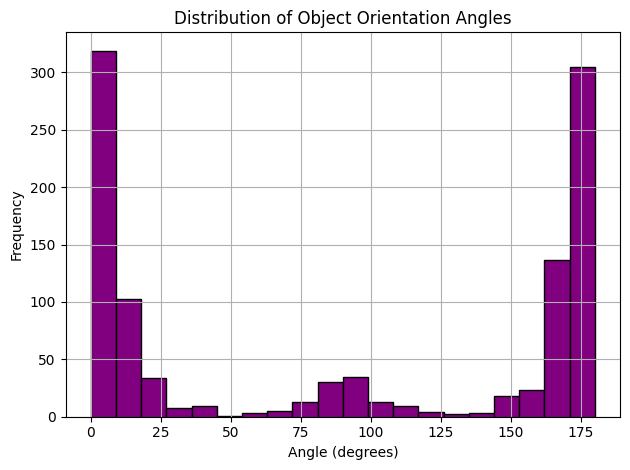

In [19]:
def estimate_image_orientations(directory, n_images=1074):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    selected_images = random.sample(image_files, min(n_images, len(image_files)))

    angles = []

    for img_file in selected_images:
        image_path = os.path.join(directory, img_file)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        _, binary = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        c = max(contours, key=cv2.contourArea)
        if len(c) < 5:
            continue

        try:
            ellipse = cv2.fitEllipse(c)
            angle = ellipse[2]  # angle of the major axis
            angles.append(angle)
        except:
            continue

    if not angles:
        print("No orientation data could be computed.")
        return

    print("\nEstimated Orientation Angles (degrees):")
    print([round(a, 2) for a in angles])
    print(f"Mean: {np.mean(angles):.2f}, Std Dev: {np.std(angles):.2f}")

    plt.hist(angles, bins=20, color='purple', edgecolor='black')
    plt.title("Distribution of Object Orientation Angles")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
estimate_image_orientations(data_folder, n_images=1074)

From the 1,074 images, the orientation angles show that objects face many different directions. The average angle is about **91°**, but the **spread is very wide** (standard deviation is **77.7°**), which means some objects are upright, some are sideways, and others are tilted in different ways. This mix can help a model learn better if it needs to handle many angles, but it could also make training harder if the model expects all images to be in the same direction.

## ***Aspect Ratio & Resolution***

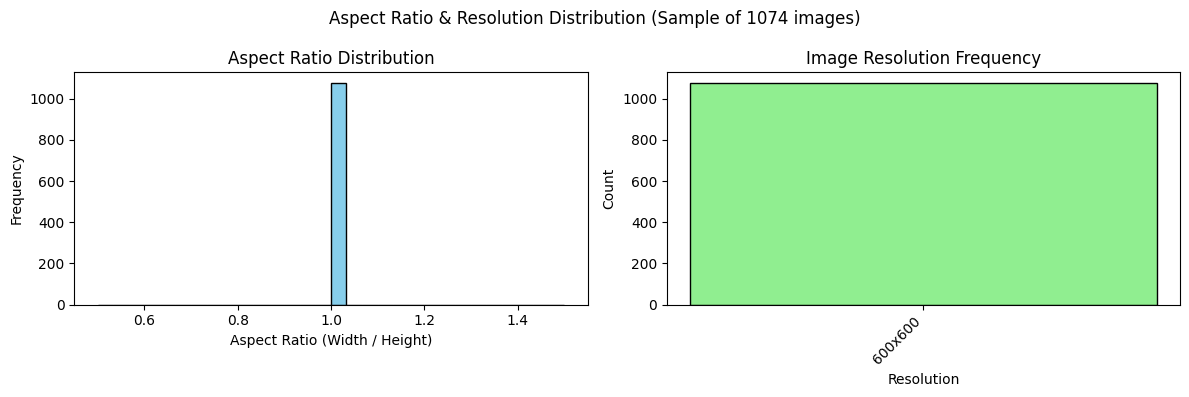

In [15]:
from collections import Counter
def display_aspect_ratio_and_resolution_distribution_simple(directory, n_images=50):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    selected_images = random.sample(image_files, min(n_images, len(image_files)))

    aspect_ratios = []
    resolutions = []

    for img_file in selected_images:
        image_path = os.path.join(directory, img_file)
        try:
            img = mpimg.imread(image_path)

            if len(img.shape) < 2:
                continue  # skip unreadable

            height, width = img.shape[:2]
            aspect_ratios.append(width / height)
            resolutions.append((width, height))

        except Exception as e:
            print(f"Error reading {image_path}: {e}")

    if not aspect_ratios:
        print("No valid images found.")
        return

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(aspect_ratios, bins=30, color='skyblue', edgecolor='black')
    plt.title("Aspect Ratio Distribution")
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Frequency")

    res_counts = Counter(resolutions)
    res_labels = [f"{w}x{h}" for (w, h) in res_counts.keys()]
    res_values = list(res_counts.values())

    plt.subplot(1, 2, 2)
    plt.bar(res_labels, res_values, color='lightgreen', edgecolor='black')
    plt.title("Image Resolution Frequency")
    plt.xlabel("Resolution")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')

    plt.suptitle("Aspect Ratio & Resolution Distribution (Sample of {} images)".format(len(aspect_ratios)))
    plt.tight_layout()
    plt.show()
display_aspect_ratio_and_resolution_distribution_simple(data_folder, n_images=1074)

All images has 1:1 ration (square) with all 600x600 pixels image resolution.

In [16]:
def print_aspect_ratio_and_resolution(directory, n_images=50):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    selected_images = random.sample(image_files, min(n_images, len(image_files)))

    aspect_ratios = []
    resolutions = []

    for img_file in selected_images:
        image_path = os.path.join(directory, img_file)
        try:
            img = mpimg.imread(image_path)

            if len(img.shape) < 2:
                continue

            height, width = img.shape[:2]
            aspect_ratios.append(round(width / height, 2))
            resolutions.append((width, height))

        except Exception as e:
            print(f"Error reading {image_path}: {e}")

    if not aspect_ratios:
        print("No valid images found.")
        return

    print("\nResolution Frequencies:")
    for res, count in Counter(resolutions).items():
        print(f"{res[0]}x{res[1]}: {count} image(s)")
print_aspect_ratio_and_resolution(data_folder, n_images=1074)


Resolution Frequencies:
600x600: 1074 image(s)


# **Split**

In [59]:
x_train_raw, x_temp_raw = train_test_split(images, test_size=0.2, random_state=42)
x_val_raw, x_test_raw = train_test_split(x_temp_raw, test_size=0.5, random_state=42)

print(f"Training data shape (x_train): {x_train_raw.shape}")
print(f"Validation data shape (x_val): {x_val_raw.shape}")
print(f"Testing data shape (x_test): {x_test_raw.shape}")

Training data shape (x_train): (859, 600, 600, 3)
Validation data shape (x_val): (107, 600, 600, 3)
Testing data shape (x_test): (108, 600, 600, 3)


# **Normalized**

In [60]:
x_train_normalized = x_train_raw.astype('float32') / 255.0
x_val_normalized = x_val_raw.astype('float32') / 255.0
x_test_normalized = x_test_raw.astype('float32') / 255.0
print(f"Images shape after normalization: {x_train_normalized.shape}")

Images shape after normalization: (859, 600, 600, 3)


In [61]:
IMG_HEIGHT = 100
IMG_WIDTH = 100

def resize_image_array(image_array, target_height, target_width):
    resized_list = []
    for img in image_array:
        resized_list.append(cv2.resize(img, (target_width, target_height)))
    return np.array(resized_list)

x_train = resize_image_array(x_train_normalized, IMG_HEIGHT, IMG_WIDTH)
x_val = resize_image_array(x_val_normalized, IMG_HEIGHT, IMG_WIDTH)
x_test = resize_image_array(x_test_normalized, IMG_HEIGHT, IMG_WIDTH)

In [62]:
x_train.shape

(859, 100, 100, 3)

# **Adding Noise**

In [63]:
def add_gaussian_noise(image_array, mean=0.0, std=0.1, noise_factor=1.0):

    image_array = image_array.astype(np.float32)
    noise = np.random.normal(mean, std * noise_factor, image_array.shape).astype(np.float32)
    noisy_image = image_array + noise
    noisy_image = np.clip(noisy_image, 0.0, 1.0)
    return noisy_image

x_train_noisy = add_gaussian_noise(x_train)
x_val_noisy = add_gaussian_noise(x_val)
x_test_noisy = add_gaussian_noise(x_test)

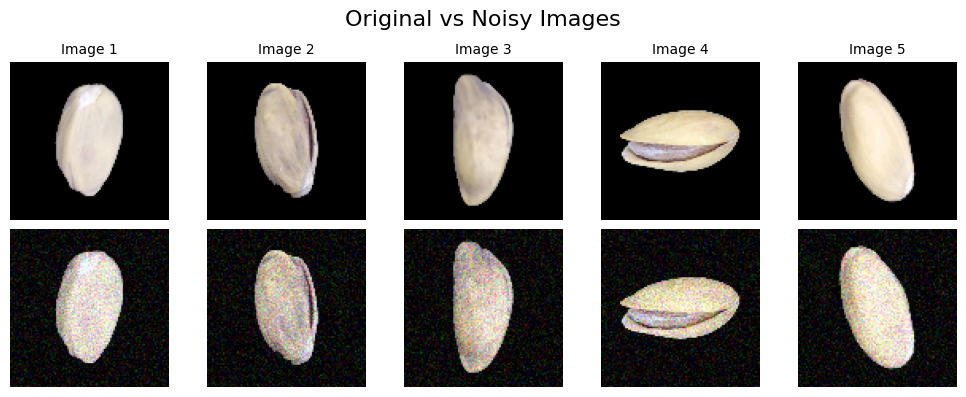

In [64]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
fig.suptitle('Original vs Noisy Images', fontsize=16)

for idx in range(5):
    batch_idx = np.random.randint(x_train.shape[0])

    ax[0, idx].imshow(x_train[batch_idx])
    ax[0, idx].set_title(f"Image {idx+1}", fontsize=10)
    ax[0, idx].axis('off')

    ax[1, idx].imshow(x_train_noisy[batch_idx])
    ax[1, idx].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# **Baseline Model**

In [65]:
# SSIM metrics
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [66]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
IMG_CHANNELS = 3 # RGB images

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

def build_autoencoder_model(input_shape):
    IMG_CHANNELS = input_shape[2]

    # Encoder
    input_layer = Input(shape=input_shape, name='input_layer')
    # conv2d
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d')(input_layer) # 100x100x3 → 100x100x32
    # max_pooling2d
    x = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d')(x) # 100x100x32 → 50x50x32
    # conv2d_1
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_1')(x) # 50x50x32 → 50x50x64
    # max_pooling2d_1
    x = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d_1')(x) # 50x50x64 → 25x25x64


    # conv2d_2 (Bottleneck/Latent Space)
    encoder_output = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_2')(x) # 25x25x64 → 25x25x64


    # Decoder
    # up_sampling2d
    x = UpSampling2D(size=(2, 2), name='up_sampling2d')(encoder_output) # 25x25x64 → 50x50x64
    # conv2d_3
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_3')(x) # 50x50x64 → 50x50x32
    # up_sampling2d_1
    x = UpSampling2D(size=(2, 2), name='up_sampling2d_1')(x) # 50x50x32 → 100x100x32
    # conv2d_4 (Output Layer)
    decoder_output = Conv2D(filters=IMG_CHANNELS, kernel_size=(3, 3), activation='sigmoid', padding='same', name='conv2d_4')(x) # 100x100x32 → 100x100x3

    autoencoder = Model(inputs=input_layer, outputs=decoder_output, name='Autoencoder_Denoising')
    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=[ssim_metric, 'mae', 'binary_crossentropy'])

    return autoencoder

**Input Layer**

* **Purpose**: Receives the input image, which contain noise.
* **Implementation**: `Input(shape=(100, 100, 3), name='input_layer')`
* **Effect**: Serves as the starting point of the encoder, accepting images of size 100×100 with 3 color channels (RGB).

---

**Convolutional Layer 1 (Encoder)**

* **Purpose**: Extracts low-level spatial features (edges, textures) from the input.
* **Implementation**: `Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d')`
* **Effect**: Outputs a feature map of shape 100×100×32 while preserving spatial dimensions with `'same'` padding.

---

**Max Pooling Layer 1 (Encoder)**

* **Purpose**: Reduces the spatial size while retaining the most important features.
* **Implementation**: `MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d')`
* **Effect**: Downsamples feature maps from 100×100×32 to 50×50×32, reducing computational cost.

---

**Convolutional Layer 2 (Encoder)**

* **Purpose**: Learns more abstract features from the previous pooled output.
* **Implementation**: `Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_1')`
* **Effect**: Maintains spatial size at 50×50 but increases depth to 64 channels.

---

**Max Pooling Layer 2 (Encoder)**

* **Purpose**: Further reduces spatial resolution while preserving critical information.
* **Implementation**: `MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d_1')`
* **Effect**: Reduces the feature map size from 50×50×64 to 25×25×64.

---

**Convolutional Layer 3 (Latent/Bottleneck)**

* **Purpose**: Acts as the compressed representation of the input data, holding only essential features.
* **Implementation**: `Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_2')`
* **Effect**: Output remains at 25×25×64, forming the latent space that captures the most important compressed information.

---

**Up Sampling Layer 1 (Decoder)**

* **Purpose**: Increases spatial resolution of the compressed representation to reconstruct the image.
* **Implementation**: `UpSampling2D(size=(2, 2), name='up_sampling2d')`
* **Effect**: Upscales feature maps from 25×25×64 to 50×50×64.

---

**Convolutional Layer 4 (Decoder)**

* **Purpose**: Reduces channel depth and refines feature maps for reconstruction.
* **Implementation**: `Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_3')`
* **Effect**: Transforms feature maps from 50×50×64 to 50×50×32.

---

**Up Sampling Layer 2 (Decoder)**

* **Purpose**: Continues increasing the spatial dimensions toward the original image size.
* **Implementation**: `UpSampling2D(size=(2, 2), name='up_sampling2d_1')`
* **Effect**: Upscales from 50×50×32 to 100×100×32.

---

**Output Convolutional Layer (Decoder Output)**

* **Purpose**: Reconstructs the denoised image with the same shape and channel count as the original input.
* **Implementation**: `Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same', name='conv2d_4')`
* **Effect**: Produces a 100×100×3 RGB image. The `sigmoid` activation ensures pixel values are in the \[0, 1] range, suitable for normalized image output.



In [28]:
autoencoder_model = build_autoencoder_model(input_shape)
autoencoder_model.summary()

Model: "Autoencoder_Denoising"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = autoencoder_model.fit(
    x_train_noisy,   # noisy inputs
    x_train,         # clean targets
    epochs=100,
    batch_size=16,
    shuffle=True,
    validation_data=(x_val_noisy, x_val)
)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - binary_crossentropy: 0.3619 - loss: 0.0851 - mae: 0.2118 - ssim_metric: 0.4366 - val_binary_crossentropy: 0.1246 - val_loss: 0.0040 - val_mae: 0.0219 - val_ssim_metric: 0.8714
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - binary_crossentropy: 0.1231 - loss: 0.0037 - mae: 0.0217 - ssim_metric: 0.8797 - val_binary_crossentropy: 0.1220 - val_loss: 0.0031 - val_mae: 0.0198 - val_ssim_metric: 0.8874
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - binary_crossentropy: 0.1203 - loss: 0.0029 - mae: 0.0191 - ssim_metric: 0.8963 - val_binary_crossentropy: 0.1199 - val_loss: 0.0024 - val_mae: 0.0173 - val_ssim_metric: 0.9018
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_crossentropy: 0.1187 - loss: 0.0024 - mae: 0.0172 - ssim_metric: 0.9075 - val_binary_crossentropy: 0.1187 - val_loss: 0.0021 - val_mae: 0.0159 - val_ssim_metric: 0.9101
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - binary_crossentropy: 0.11

## ***Evaluate***

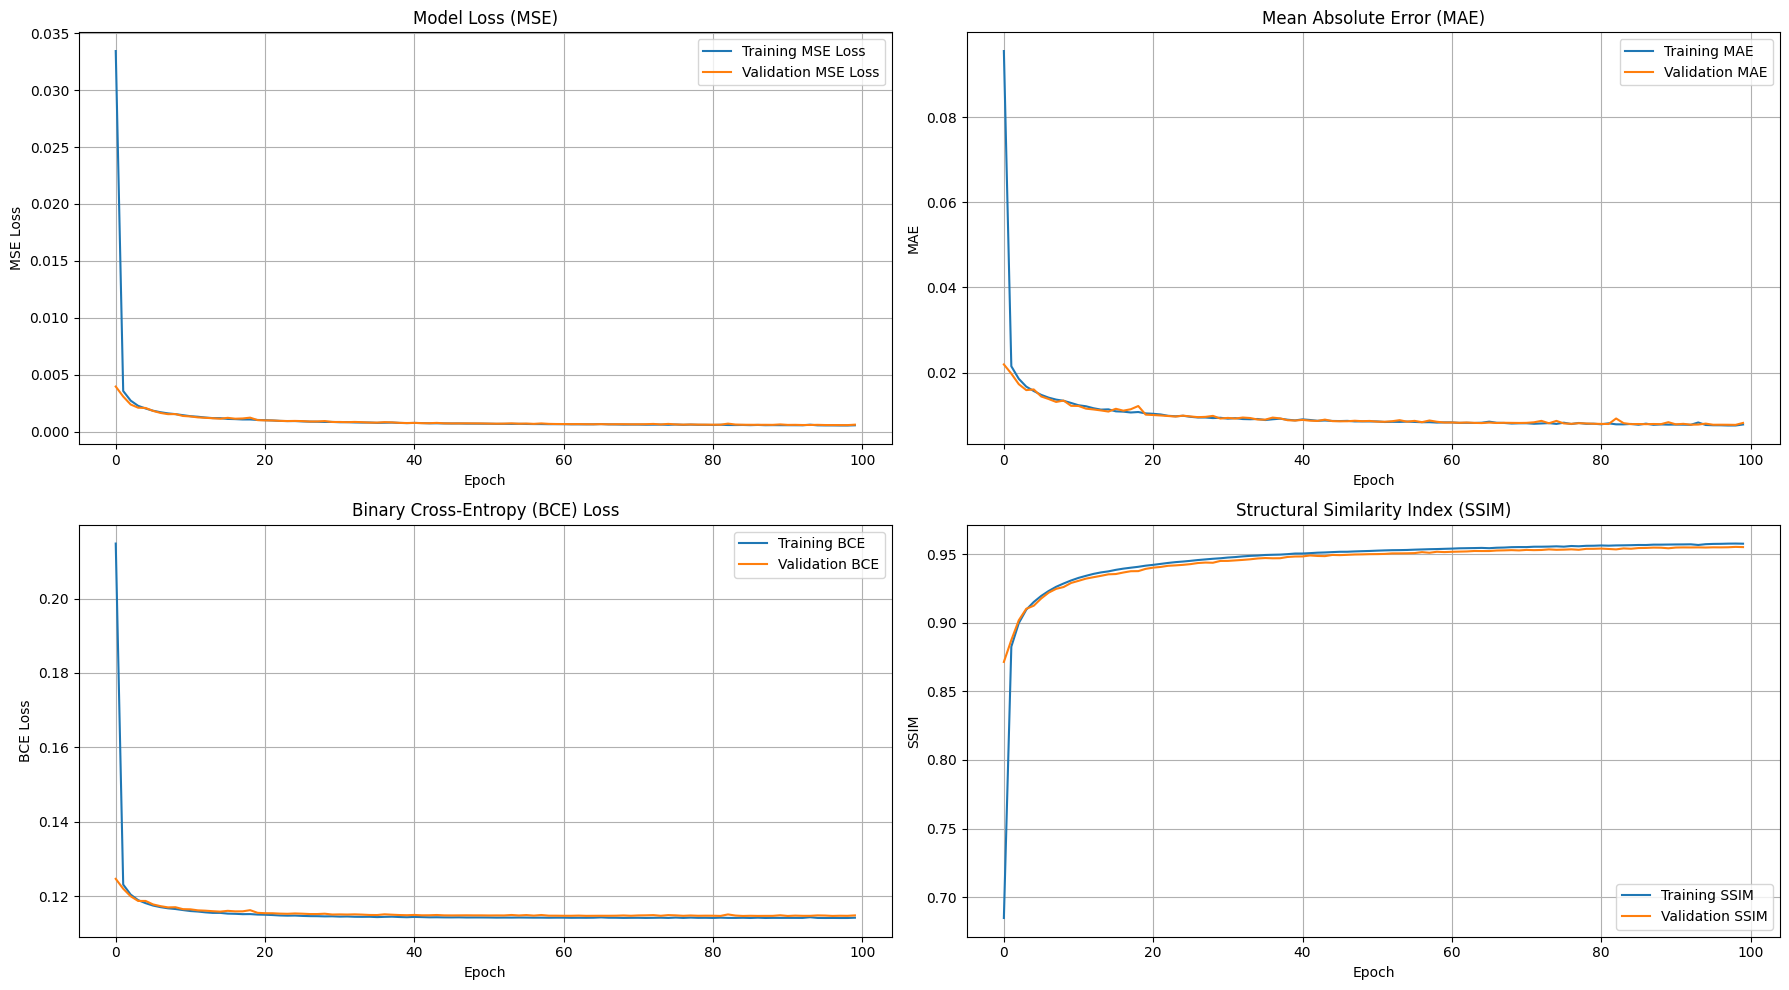

In [30]:
# Training History: Loss, MAE, BCE, SSIM
plt.figure(figsize=(18, 10))

# MSE Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training MSE Loss')
plt.plot(history.history['val_loss'], label='Validation MSE Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# MAE
if 'mae' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

# Binary Cross-Entropy
if 'binary_crossentropy' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['binary_crossentropy'], label='Training BCE')
    plt.plot(history.history['val_binary_crossentropy'], label='Validation BCE')
    plt.title('Binary Cross-Entropy (BCE) Loss')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.legend()
    plt.grid(True)

# SSIM
if 'ssim_metric' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['ssim_metric'], label='Training SSIM')
    plt.plot(history.history['val_ssim_metric'], label='Validation SSIM')
    plt.title('Structural Similarity Index (SSIM)')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**1. Model Loss (MSE) Plot:**
The Mean Squared Error (MSE) loss, representing reconstruction error, shows rapid convergence for both training and validation sets. Both curves quickly decrease and stabilize at a very low value, indicating the model efficiently learned to minimize the discrepancies between its output and the target images.
<br>
<br>
**2. Mean Absolute Error (MAE) Plot:**
The Mean Absolute Error (MAE) plot, another measure of reconstruction accuracy, mirrors the MSE plot's trend. Training and validation MAE values drop sharply and then plateau at near-zero levels. This demonstrates the model's consistent ability to produce highly accurate reconstructions with minimal average pixel-wise deviations.
<br>
<br>
**3. Binary Cross-Entropy (BCE) Loss Plot:**
The Binary Cross-Entropy (BCE) loss exhibits a similar rapid decline and subsequent flattening for both training and validation data. Assuming BCE is a relevant metric for a specific aspect of your denoising task (e.g., pixel classification or probability output), its behavior suggests effective learning and stable performance in that regard.
<br>
<br>
**4. Structural Similarity Index (SSIM) Plot:**
The Structural Similarity Index (SSIM) plot, crucial for assessing image quality, shows exceptional performance. Both training and validation SSIM values quickly ascend and consistently remain above 0.95. This indicates the model effectively preserves the structural integrity and visual fidelity of the images during the denoising process.

In [31]:
print("\nEvaluating model on the TEST SET")
results = autoencoder_model.evaluate(x_test_noisy, x_test, batch_size=16, verbose=1)

test_mse   = results[0]  # loss
test_ssim  = results[1]
test_mae   = results[2]
test_bce   = results[3]

print(f"Final Test Loss (MSE):         {test_mse:.6f}")
print(f"Final Test SSIM:               {test_ssim:.6f}")
print(f"Final Test MAE:                {test_mae:.6f}")
print(f"Final Test Binary CrossEntropy:{test_bce:.6f}")


Evaluating model on the TEST SET
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - binary_crossentropy: 0.1137 - loss: 5.8686e-04 - mae: 0.0080 - ssim_metric: 0.9563
Final Test Loss (MSE):         0.000584
Final Test SSIM:               0.956589
Final Test MAE:                0.007970
Final Test Binary CrossEntropy:0.114504


* **MSE: 0.000584**: The model’s reconstruction error is extremely low, meaning it has learned to denoise input images with high precision. Only \~0.06% average squared pixel error meaning it's excellent performance.
* **SSIM: 0.9566**:  The model preserves structural and perceptual similarity very well. A score above 0.95 indicates the denoised outputs are visually almost identical to the original clean images.
* **MAE: 0.0080**:  On average, the reconstructed pixel values differ from the original by less than 1%. This further confirms accurate and consistent reconstruction.
* **Binary Cross-Entropy: 0.1145**: A low BCE suggests that the reconstructed pixel intensities align well with the original distributions.

---
**What this all means:**

The model performs **remarkably well on noisy test data**, achieving both **numerically low errors (MSE & MAE)** and **high perceptual quality (SSIM)**. The **very low MSE and MAE** values indicate the autoencoder is nearly perfect at reconstructing pixel values. At the same time, the **high SSIM** score assures us that it’s not just numerically correct, but also visually faithful to the clean inputs. The **low Binary Cross-Entropy** adds further confidence that even probabilistic pixel differences (if present) are being reconstructed correctly.


In [33]:
# predict denoised images from the noisy test inputs
reconstructed_images = autoencoder_model.predict(x_test_noisy)

ssim_scores = []
for denoised, original in zip(reconstructed_images, x_test):
    score = ssim(original, denoised, data_range=1.0, channel_axis=-1)
    ssim_scores.append(score)

ssim_scores = np.array(ssim_scores)

print("📊 SSIM Evaluation - Baseline Autoencoder")
print("Mean SSIM:", np.mean(ssim_scores))
print("Max SSIM:", np.max(ssim_scores))
print("Min SSIM:", np.min(ssim_scores))
print("Index with highest SSIM:", np.argmax(ssim_scores))
print("Index with lowest SSIM:", np.argmin(ssim_scores))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
📊 SSIM Evaluation - Baseline Autoencoder
Mean SSIM: 0.9601987
Max SSIM: 0.98353285
Min SSIM: 0.9185086
Index with highest SSIM: 104
Index with lowest SSIM: 9


The baseline autoencoder shows **strong performance** in terms of Structural Similarity Index (SSIM), with a **mean SSIM of 0.9602**, indicating that, on average, the reconstructed images are highly similar to the original clean images. This suggests the model has effectively learned to preserve the structural and perceptual details during denoising.

The **highest SSIM score is 0.9835 at index 104**, meaning that for this particular sample, the model achieved near-perfect reconstruction. Meanwhile, the **lowest SSIM score is 0.9185 at index 9**, which is still relatively high, though it implies that this image may have had more complex noise or structure that the model found slightly harder to restore.

Overall, the **narrow SSIM range** (from \~0.92 to \~0.98) reflects consistent and reliable reconstruction quality across the test set.



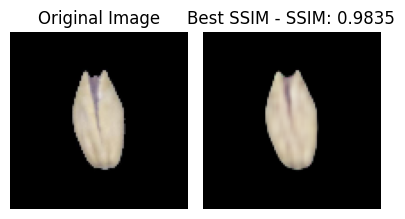

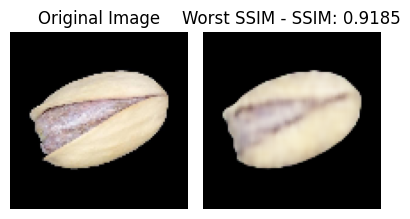

In [34]:
# visualize the best and worst denoising results
for idx, label in zip([np.argmax(ssim_scores), np.argmin(ssim_scores)], ["Best SSIM", "Worst SSIM"]):
    plt.figure(figsize=(4, 4))

    # original image
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx])
    plt.title("Original Image")
    plt.axis("off")

    # denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_images[idx])
    plt.title(f"{label} - SSIM: {ssim_scores[idx]:.4f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## ***Prediction***

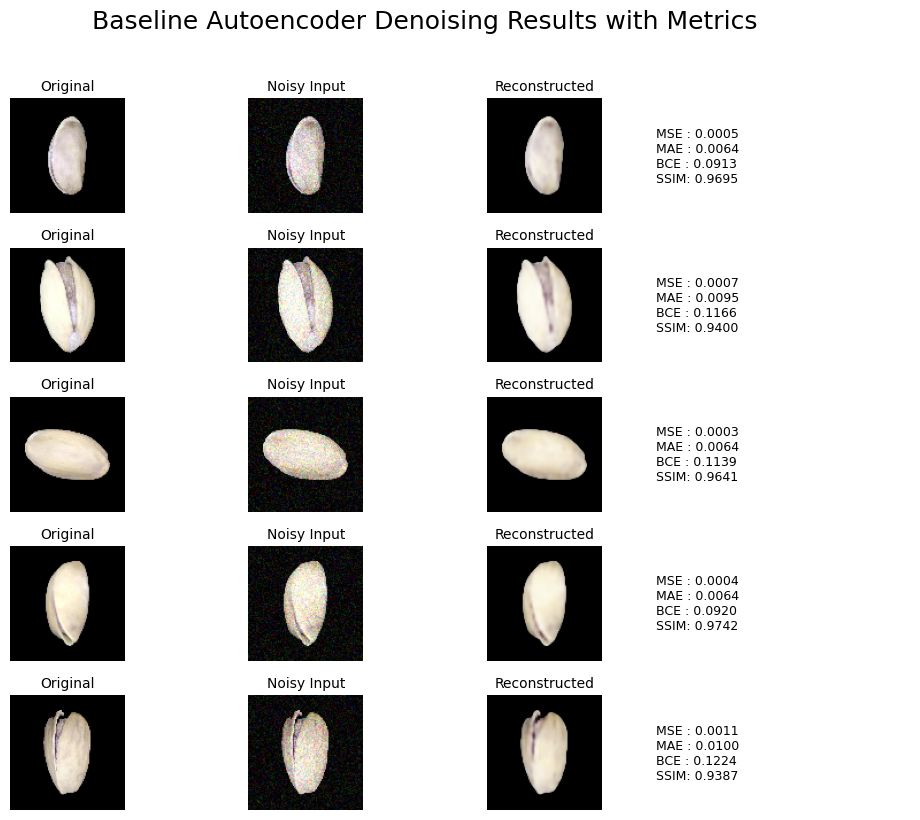

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
num_images_to_show = min(5, len(x_test))

fig, axes = plt.subplots(num_images_to_show, 4, figsize=(10, 8))
fig.suptitle('Baseline Autoencoder Denoising Results with Metrics', fontsize=18, y=1.02)

titles = ['Original', 'Noisy Input', 'Reconstructed']

for i in range(num_images_to_show):
    orig = x_test[i]
    noisy = x_test_noisy[i]
    recon = reconstructed_images[i]

    images = [orig, noisy, recon]
    for j in range(3):
        axes[i, j].imshow(images[j])
        axes[i, j].set_title(titles[j], fontsize=10)
        axes[i, j].axis('off')

    orig_flat = orig.flatten()
    recon_flat = recon.flatten()

    mse = mean_squared_error(orig_flat, recon_flat)
    mae = mean_absolute_error(orig_flat, recon_flat)
    bce = tf.keras.losses.binary_crossentropy(orig, recon).numpy().mean()
    ssim = tf.image.ssim(tf.convert_to_tensor(orig), tf.convert_to_tensor(recon), max_val=1.0).numpy().mean()

    axes[i, 3].axis('off')
    metrics_text = (
        f"MSE : {mse:.4f}\n"
        f"MAE : {mae:.4f}\n"
        f"BCE : {bce:.4f}\n"
        f"SSIM: {ssim:.4f}"
    )
    axes[i, 3].text(0, 0.5, metrics_text, fontsize=9, va='center')

plt.tight_layout()
plt.show()

# **Modified Model**

## ***U-Net Architecture***

The U-Net model is a versatile convolutional neural network primarily known for **image segmentation**, where it remaps image pixels to segmentation masks (labels). However, it's also adapted for tasks like **upscaling image resolution** (transforming low-resolution images to high-resolution) and in **diffusion models** (transforming Gaussian noise into newly generated images).

Its name, U-Net, comes from its distinctive **U-shaped architecture where the encoder and decoder sections are symmetrical and connected.**

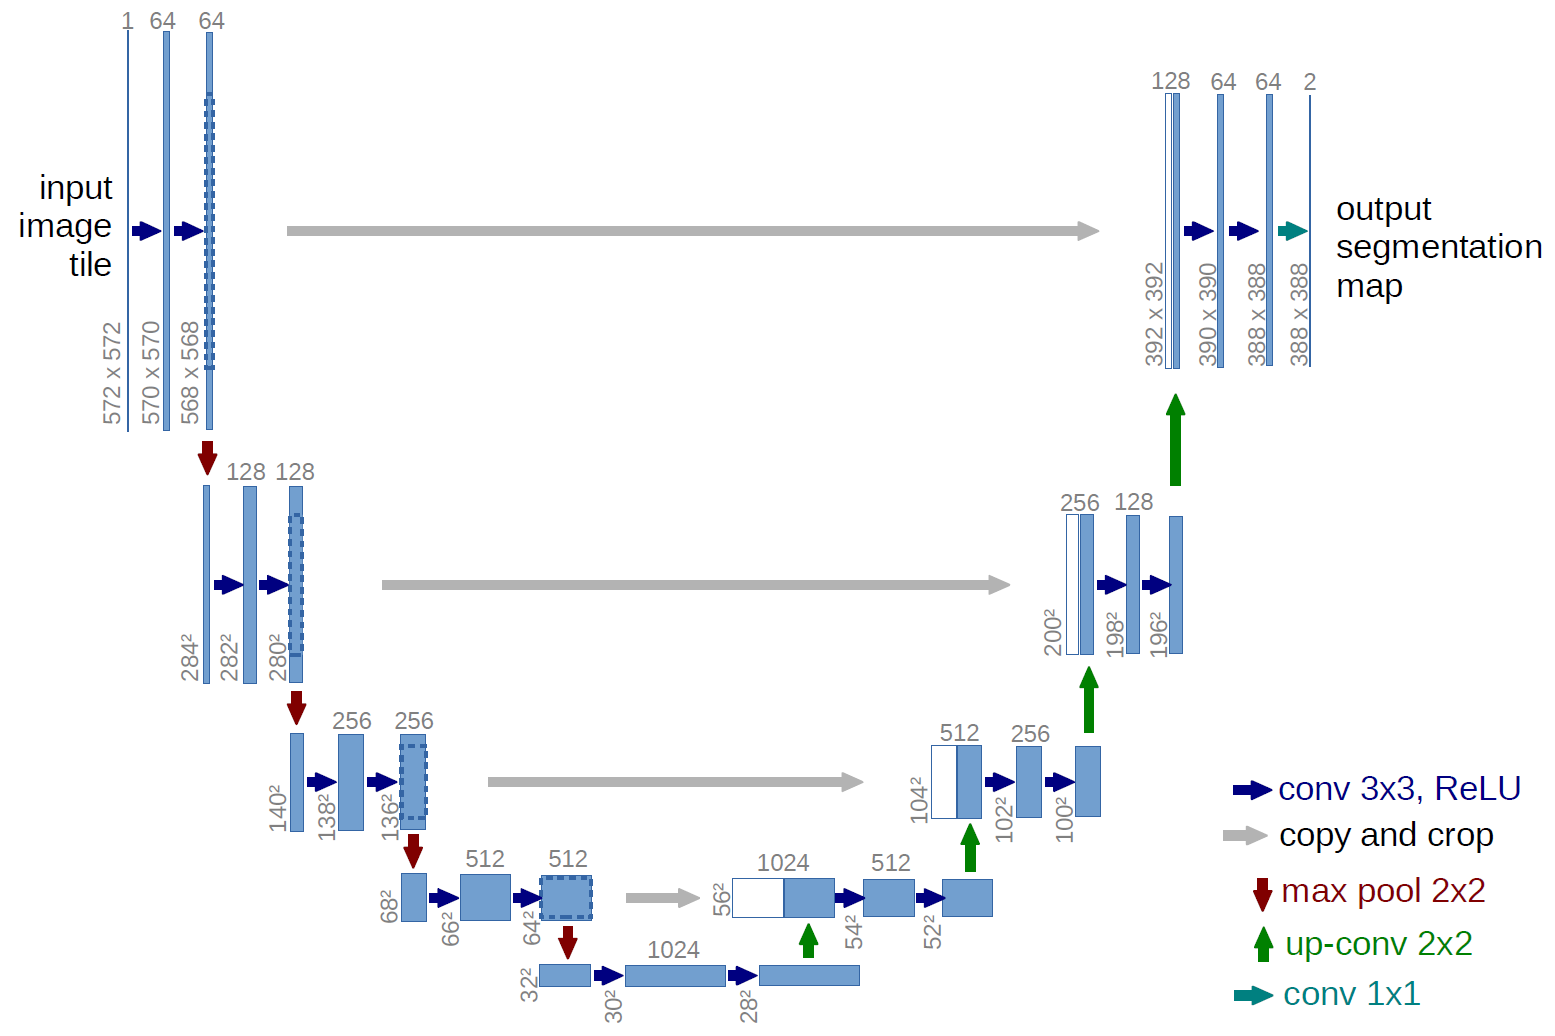

**Encoder**

The primary role of the encoder is to **extract features** from the input image and capture its context.
  * It typically consists of multiple stages (often 4 blocks).
  * Each stage is made up of a series of **repeated 3x3 convolutional layers**. After each convolutional layer, a **ReLU (Rectified Linear Unit)** activation function is applied element-wise to introduce non-linearity. Some variations also include Batch Normalization after convolution and before ReLU for stable training.
  * Between these stages, **2x2 max pooling layers are used to downsample the feature maps**. This reduces the spatial dimensions (height and width) of the features.
  * To compensate for this reduction in spatial information and to learn more complex features, the number of feature channels (filters) is typically **doubled** after each downsampling/max pooling step.

  

**Bottleneck**

The bottleneck forms the bridge at the bottom of the 'U', **connecting the encoder to the decoder**.
  * This section usually consists of two **3x3 convolutional** layers followed by **ReLU** (and potentially Batch Normalization), similar to the encoder blocks, but without a max pooling layer. In some designs, it might use a larger number of filters (ex: 1024).
  * Downsample with 2x2 max pooling
  * Repeated 3x3 convolutional layers + ReLU
  * Double channels with Convolutional Layer after max pool
  * Upsample followed by a 2x2 convolution
  * It processes the most abstract and condensed feature representation from the encoder before the upsampling process begins.

**Decoder**

Think of the decoder as the part of the U-Net that carefully **rebuilds the image into a detailed map**. Its main job is to take the summarized information from the earlier stages and blow it back up to the original image size, figuring out exactly where everything should be.
  * Each stage typically starts with an upsampling operation to increase the spatial dimensions. This is often done using a **2x2 up-convolution** (transposed convolution), which also learns to deconvolve features. This step usually halves the number of feature channels.
  * The crucial skip connections (or **connecting paths**) come into play here. Features from the corresponding (symmetrical) stage in the encoder are **concatenated** with the upsampled features in the decoder.
    * The encoder features provide high-resolution, spatial information (like the exact pixels where an object is).
    * The decoder features (from the upsampling path) contain more semantic information (like "this area contains a bike").* Combining these through concatenation allows the decoder to use both types of information, leading to pixel-perfect segmentations.
  * Following concatenation, each decoder stage usually applies two **3x3 convolutional layers + ReLU (and possibly Batch Normalization),** similar to the encoder blocks, to refine the combined features

Using **U-Net architecture** for a Denoising Autoencoder (DAE) is actually really helpful. Unlike regular autoencoders that just keep shrinking the image down and then try to rebuild it, U-Net adds **skip connections**, so while it’s compressing the image, it also saves important details and brings them back during reconstruction.

This is super useful for denoising, because it helps the model not just guess the clean image, but also **remember the original structure** better. So, overall, the U-Net helps the DAE make cleaner and more accurate outputs.



In [67]:
def unet_denoising(input_size=(100, 100, 3)):
    inputs = Input(input_size)

    # Encoder (3 levels only)
    c1 = Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)  # 100 → 50

    c2 = Conv2D(128, (3, 3), padding='same')(p1)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)  # 50 → 25

    # Bottleneck
    c3 = Conv2D(256, (3, 3), padding='same')(p2)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    # Decoder (upsample)
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)  # 25 → 50
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), padding='same')(u4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(128, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)  # 50 → 100
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), padding='same')(u5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(64, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c5)

    return Model(inputs=inputs, outputs=outputs)

**Input Layer**

* **Purpose**: Receives the input image, which contains noise.
* **Implementation**: `Input(shape=(100, 100, 3))`
* **Effect**: Accepts RGB images of size 100×100 as input to the network.

---

**Encoder Block 1**

**Conv2D Layer 1**

* **Purpose**: Extracts low-level spatial features such as edges.
* **Implementation**: `Conv2D(64, (3, 3), padding='same') + Activation('relu')`
* **Effect**: Maintains shape (100×100×64) with ReLU for non-linearity.

**Conv2D Layer 2 + BatchNorm**

* **Purpose**: Deepens feature extraction while normalizing activations.
* **Implementation**: `Conv2D(64, (3, 3), padding='same') → BatchNormalization() → Activation('relu')`
* **Effect**: Adds stability and non-linearity; output still 100×100×64.

**MaxPooling2D Layer 1**

* **Purpose**: Downsamples the feature map to reduce spatial dimensions.
* **Implementation**: `MaxPooling2D((2, 2))`
* **Effect**: Reduces to 50×50×64.

---

**Encoder Block 2**

**Conv2D Layer 3**

* **Purpose**: Learns mid-level abstract features.
* **Implementation**: `Conv2D(128, (3, 3), padding='same') + Activation('relu')`
* **Effect**: Output becomes 50×50×128.

**Conv2D Layer 4 + BatchNorm**

* **Purpose**: Continues feature refinement and stabilization.
* **Implementation**: `Conv2D(128, (3, 3), padding='same') → BatchNormalization() → Activation('relu')`
* **Effect**: Maintains 50×50×128.

**MaxPooling2D Layer 2**

* **Purpose**: Further spatial downsampling.
* **Implementation**: `MaxPooling2D((2, 2))`
* **Effect**: Down to 25×25×128.

---

**Bottleneck (Latent Representation)**

**Conv2D Layers 5 & 6 + BatchNorm**

* **Purpose**: Encodes the compressed core features of the input.
* **Implementation**:
  `Conv2D(256, (3, 3), padding='same') + ReLU`
  `Conv2D(256, (3, 3), padding='same') + BatchNorm + ReLU`
* **Effect**: Output stays at 25×25×256. This bottleneck holds essential information.

---

**Decoder Block 1**

**Conv2DTranspose + Skip Connection**

* **Purpose**: Upsamples feature maps and combines them with earlier features.
* **Implementation**: `Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') → concatenate([..., c2])`
* **Effect**: Upsamples to 50×50×128 and enriches with encoder features.

**Conv2D Layers 7 & 8 + BatchNorm**

* **Purpose**: Refines merged features for reconstruction.
* **Implementation**:
  `Conv2D(128, (3, 3), padding='same') + ReLU`
  `Conv2D(128, (3, 3), padding='same') + BatchNorm + ReLU`
* **Effect**: Output remains at 50×50×128.

---

**Decoder Block 2**

**Conv2DTranspose + Skip Connection**

* **Purpose**: Final upsampling to match input dimensions.
* **Implementation**: `Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') → concatenate([..., c1])`
* **Effect**: Upsamples to 100×100×64.

**Conv2D Layers 9 & 10 + BatchNorm**

* **Purpose**: Final feature refinement before reconstruction.
* **Implementation**:
  `Conv2D(64, (3, 3), padding='same') + ReLU`
  `Conv2D(64, (3, 3), padding='same') + BatchNorm + ReLU`
* **Effect**: Output remains at 100×100×64.

---
**Output Layer**

* **Purpose**: Produces the final reconstructed (denoised) image.
* **Implementation**: `Conv2D(3, (1, 1), activation='sigmoid')`
* **Effect**: Outputs a 100×100×3 image with pixel values in \[0, 1] via `sigmoid`, matching original image shape.



In [68]:
unet_model = unet_denoising(input_size=(100, 100, 3))
unet_model.compile(optimizer='adam', loss='mse', metrics=[ssim_metric, 'mae', 'binary_crossentropy'])

In [69]:
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 100, 100,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 100, 100,  │          0 │ conv2d_11[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 100, 100,  │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 50,    │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 50, 50,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 50, 50,    │          0 │ conv2d_13[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 50, 50,    │    147,584 │ activation_12[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 25, 25,    │          0 │ activation_13[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 25, 25,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 25, 25,    │          0 │ conv2d_15[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 25, 25,    │    590,080 │ activation_14[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │      1,024 │ conv2d_16[0][0] 

 Total params: 1,865,539 (7.12 MB)

 Trainable params: 1,864,259 (7.11 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [70]:
history2 = unet_model.fit(
    x_train_noisy, x_train,
    validation_data=(x_val_noisy, x_val),
    epochs=100,
    batch_size=16,
    shuffle=True
)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - binary_crossentropy: 0.4367 - loss: 0.0726 - mae: 0.2322 - ssim_metric: 0.1946 - val_binary_crossentropy: 2.0077 - val_loss: 0.1580 - val_mae: 0.3387 - val_ssim_metric: 0.1114
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - binary_crossentropy: 0.2129 - loss: 0.0092 - mae: 0.0893 - ssim_metric: 0.2888 - val_binary_crossentropy: 2.2918 - val_loss: 0.0989 - val_mae: 0.2288 - val_ssim_metric: 0.1134
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - binary_crossentropy: 0.1797 - loss: 0.0042 - mae: 0.0599 - ssim_metric: 0.3174 - val_binary_crossentropy: 0.5209 - val_loss: 0.0153 - val_mae: 0.1070 - val_ssim_metric: 0.2364
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - binary_crossentropy: 0.1603 - loss: 0.0023 - mae: 0.0442 - ssim_metric: 0.3453 - val_binary_crossentropy: 0.1787 - val_loss: 0.0080 - val_mae: 0.0801 - val_ssim_metric: 0.2790
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - binary_crossentropy: 0.

## ***Evaluate***

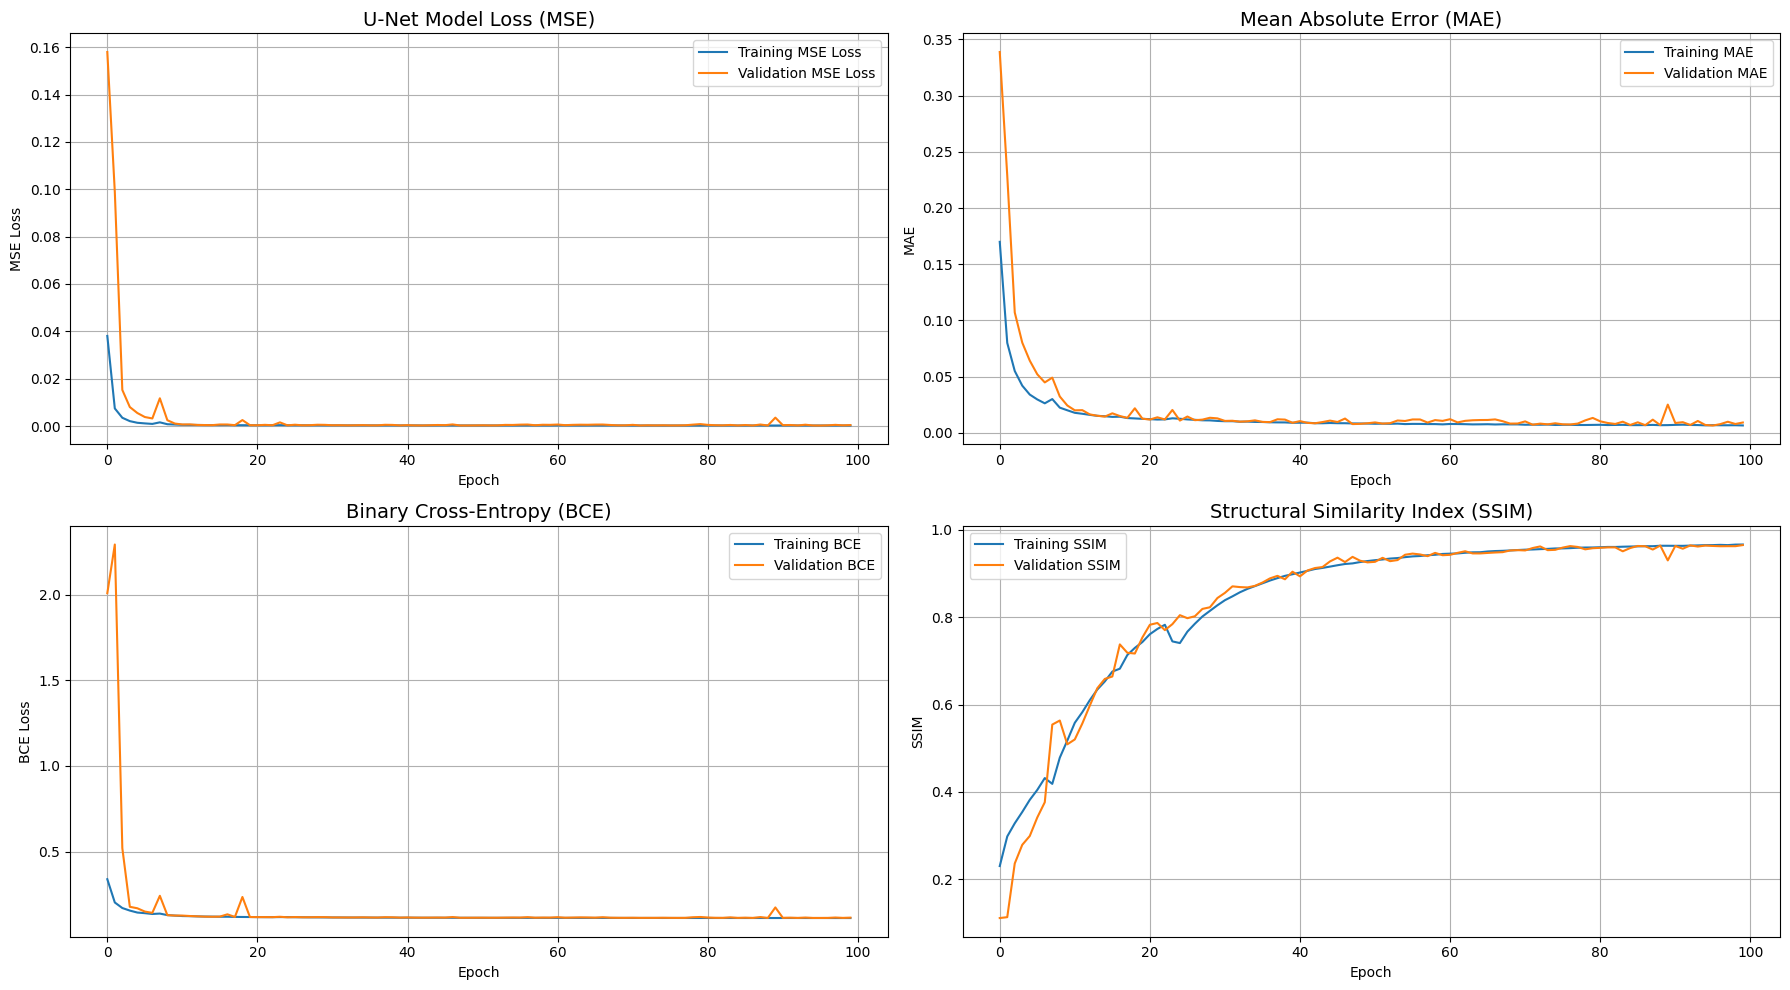

In [71]:
# U-Net Training History: MSE, MAE, BCE, SSIM
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(history2.history.get('loss'), label='Training MSE Loss')
plt.plot(history2.history.get('val_loss'), label='Validation MSE Loss')
plt.title('U-Net Model Loss (MSE)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

if 'mae' in history2.history:
    plt.subplot(2, 2, 2)
    plt.plot(history2.history['mae'], label='Training MAE')
    plt.plot(history2.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error (MAE)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

if 'binary_crossentropy' in history2.history:
    plt.subplot(2, 2, 3)
    plt.plot(history2.history['binary_crossentropy'], label='Training BCE')
    plt.plot(history2.history['val_binary_crossentropy'], label='Validation BCE')
    plt.title('Binary Cross-Entropy (BCE)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.legend()
    plt.grid(True)

if 'ssim_metric' in history2.history:
    plt.subplot(2, 2, 4)
    plt.plot(history2.history['ssim_metric'], label='Training SSIM')
    plt.plot(history2.history['val_ssim_metric'], label='Validation SSIM')
    plt.title('Structural Similarity Index (SSIM)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**1. Model Loss (MSE) Plot:**
The Mean Squared Error (MSE) loss, which is a key metric for a DAE as it quantifies the reconstruction error, shows excellent behavior. Both the training (blue) and validation (orange) curves exhibit a rapid descent in the initial epochs, quickly stabilizing at very low values close to zero. This indicates that your DAE efficiently learned to minimize the difference between its output (denoised image) and the original clean image, achieving consistently low reconstruction error on both seen and unseen data.
<br>
<br>
**2. Mean Absolute Error (MAE) Plot:**
The Mean Absolute Error (MAE) plot, another measure of reconstruction accuracy that is less sensitive to outliers than MSE, mirrors the positive trend observed in the MSE plot. Both training and validation MAE values decrease sharply and then plateau at very low levels. This confirms that the DAE model consistently produces highly accurate denoised outputs with minimal average pixel-wise deviations. The slight bump in validation MAE later on is minor and likely just noise, not indicative of significant issues.
<br>
<br>
**3. Binary Cross-Entropy (BCE) Plot:**
The Binary Cross-Entropy (BCE) loss plot, while less common for general image denoising (which typically focuses on pixel intensity reconstruction), is present here. If your DAE design incorporates elements that necessitate a binary classification or probability output (like for specific noise types or masks), this plot shows effective learning. Both the training and validation BCE curves rapidly decrease and then flatten out at a very low value. This suggests that if a binary decision component is part of your DAE, it's performing well and consistently.
<br>
<br>
**4. Structural Similarity Index (SSIM) Plot:**
The Structural Similarity Index (SSIM) plot is a crucial metric for a denoising autoencoder, as it assesses how well the structural information and perceptual quality of the original image are preserved in the denoised output. Both the training and validation SSIM values demonstrate strong improvement, rapidly rising and then plateauing at high values (approaching 1.0). This is an excellent outcome, indicating that your DAE is highly effective at not only reducing noise but also maintaining the visual fidelity and important structural details of the images, which is paramount for a successful denoising task.

In [72]:
print("\nEvaluating U-Net model on the TEST SET...")
results2 = unet_model.evaluate(x_test_noisy, x_test, batch_size=16, verbose=1)

test_mse2   = results2[0]  # loss
test_ssim2  = results2[1]
test_mae2   = results2[2]
test_bce2   = results2[3]

print(f"Final Test Loss (MSE):         {test_mse2:.6f}")
print(f"Final Test SSIM:               {test_ssim2:.6f}")
print(f"Final Test MAE:                {test_mae2:.6f}")
print(f"Final Test Binary CrossEntropy:{test_bce2:.6f}")


Evaluating U-Net model on the TEST SET...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - binary_crossentropy: 0.1143 - loss: 4.0973e-04 - mae: 0.0089 - ssim_metric: 0.9658
Final Test Loss (MSE):         0.000408
Final Test SSIM:               0.965681
Final Test MAE:                0.008883
Final Test Binary CrossEntropy:0.115057


* **MSE: 0.000408**: The reconstruction error is **very low**, meaning the model has learned to denoise the images precisely. On average, there's only \~0.04% squared pixel error, even better than before.

* **SSIM: 0.9657**: The structural similarity remains **excellent**. A score above 0.96 means the output images are visually very close to the original clean versions.

* **MAE: 0.0089**: The average difference between predicted and actual pixel values is still under 1%, showing the model is consistently accurate in reconstruction.

* **Binary Cross-Entropy: 0.1151**: This low value shows that the predicted pixel intensity distributions align closely with the original, which is important for pixel-wise detail.

---

**What this all means:**

The U-Net model continues to perform **extremely well** on the denoising task. With a **lower MSE and MAE**, it shows even better precision than previous versions. The **high SSIM** score confirms that the denoised images not only match the originals in data but also in visual structure. The **low BCE** further backs up that the model handles pixel-level information smoothly. All of this points to a well-generalized and highly effective denoising system.


In [51]:
from skimage.metrics import structural_similarity as ssim
model_name = "U-Net"
reconstructed_images2 = unet_model.predict(x_test_noisy)

ssim_scores2 = []
for denoised, original in zip(reconstructed_images2, x_test):
    score = ssim(original, denoised, data_range=1.0, channel_axis=-1)
    ssim_scores2.append(score)

ssim_scores2 = np.array(ssim_scores2)

print("Mean SSIM:", np.mean(ssim_scores2))
print("Max SSIM:", np.max(ssim_scores2))
print("Min SSIM:", np.min(ssim_scores2))
print("Index with highest SSIM:", np.argmax(ssim_scores2))
print("Index with lowest SSIM:", np.argmin(ssim_scores2))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Mean SSIM: 0.96656483
Max SSIM: 0.988864
Min SSIM: 0.94123006
Index with highest SSIM: 104
Index with lowest SSIM: 56


The U-Net model performs really well in terms of image quality. The **mean SSIM is 0.9666**, which means most of the reconstructed images are **very close to the original clean versions**. The **highest SSIM (0.9889)** shows that some images were nearly perfect, while even the **lowest SSIM (0.9412)** is still quite high, indicating the model does a good job across the board. The model is not just accurate overall, but also **consistently reliable** across different test samples.


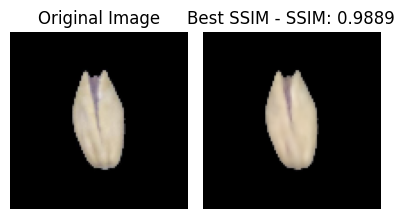

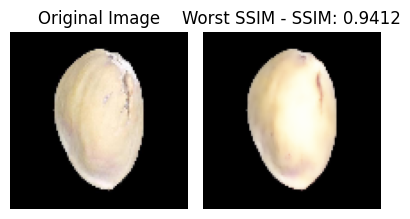

In [53]:
# Visualize the best and worst denoising results
for idx, label in zip([np.argmax(ssim_scores2), np.argmin(ssim_scores2)], ["Best SSIM", "Worst SSIM"]):
    plt.figure(figsize=(4, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx])
    plt.title("Original Image")
    plt.axis("off")

    # Denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_images2[idx])
    plt.title(f"{label} - SSIM: {ssim_scores2[idx]:.4f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## ***Prediction***

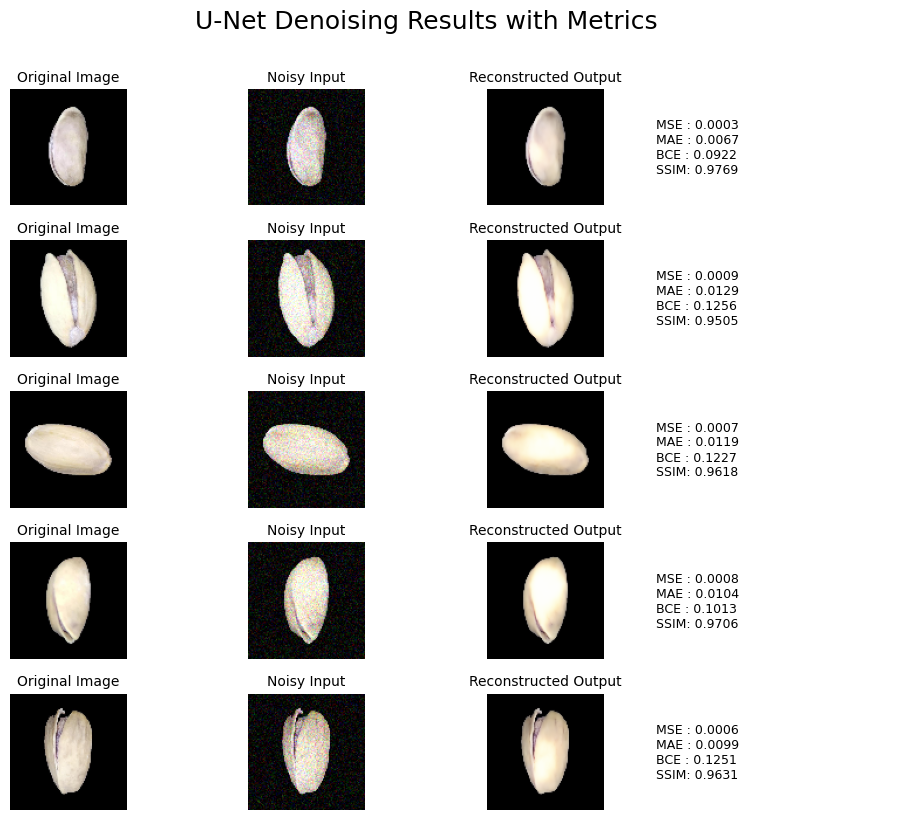

In [54]:
num_images_to_show = min(5, len(x_test))

fig, axes = plt.subplots(num_images_to_show, 4, figsize=(10, 8))
fig.suptitle(f'{model_name} Denoising Results with Metrics', fontsize=18, y=1.02)

titles = ['Original Image', 'Noisy Input', 'Reconstructed Output']

for i in range(num_images_to_show):
    orig = x_test[i]
    noisy = x_test_noisy[i]
    recon = reconstructed_images2[i]

    images = [orig, noisy, recon]
    for j in range(3):
        axes[i, j].imshow(images[j])
        axes[i, j].set_title(titles[j], fontsize=10)
        axes[i, j].axis('off')

    orig_flat = orig.flatten()
    recon_flat = recon.flatten()

    mse = mean_squared_error(orig_flat, recon_flat)
    mae = mean_absolute_error(orig_flat, recon_flat)
    bce = tf.keras.losses.binary_crossentropy(orig, recon).numpy().mean()
    ssim = tf.image.ssim(tf.convert_to_tensor(orig), tf.convert_to_tensor(recon), max_val=1.0).numpy().mean()

    axes[i, 3].axis('off')
    metrics_text = (
        f"MSE : {mse:.4f}\n"
        f"MAE : {mae:.4f}\n"
        f"BCE : {bce:.4f}\n"
        f"SSIM: {ssim:.4f}"
    )
    axes[i, 3].text(0, 0.5, metrics_text, fontsize=9, va='center')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# **Fine Tuned Model**

For the fine-tuned model, we use **the exact same U-Net architecture** as before. The only difference is that now we’re using a **GridSearch tuner** to help find the best combination of hyperparameters. Instead of guessing what values work best, GridSearch will automatically try out **different settings** and tell us which one gives the lowest validation loss.

In this case, we test combinations of:

* **Activation functions**: `'relu'` and `'elu'`
* **Number of filters in the first conv block (`filters_c1`)**: `64` and `128`
* **Learning rates (`lr`)**: `1e-3` and `1e-4`

That gives us **2 × 2 × 2 = 8 total combinations**, and GridSearch runs a separate training session for each. After training, it selects the model with the **best validation performance**, so we get the most optimized version of our U-Net for the denoising task.

In [73]:
def build_unet(hp):
    inputs = Input((100, 100, 3))

    act = hp.Choice('activation', ['relu', 'elu'])
    filters_c1 = hp.Choice('filters_c1', [64, 128])
    lr = hp.Choice('lr', [1e-3, 1e-4])  # 2 options

    def conv_block(x, filters, name):
        x = Conv2D(filters, (3, 3), padding='same', name=name+'_conv1')(x)
        x = Activation(act)(x)
        x = Conv2D(filters, (3, 3), padding='same', name=name+'_conv2')(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        return x

    # Encoder
    c1 = conv_block(inputs, filters_c1, 'c1')
    p1 = MaxPooling2D((2, 2))(c1)

    filters_c2 = 128
    c2 = conv_block(p1, filters_c2, 'c2')
    p2 = MaxPooling2D((2, 2))(c2)

    filters_c3 = 256
    c3 = conv_block(p2, filters_c3, 'c3')

    # Decoder
    u4 = Conv2DTranspose(filters_c2, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = conv_block(u4, filters_c2, 'c4')

    u5 = Conv2DTranspose(filters_c1, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = conv_block(u5, filters_c1, 'c5')

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=[ssim_metric, 'mae', 'binary_crossentropy'])
    return model

In [74]:
tuner = GridSearch(
    build_unet,
    objective='val_loss',
    max_trials=None,  # GridSearch will compute all 4 combinations
    directory='unet_gridsearch',
    project_name='denoising_unet'
)

tuner.search(
    x_train_noisy, x_train,
    validation_data=(x_val_noisy, x_val),
    epochs=50,
    batch_size=16,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Trial 8 Complete [00h 04m 40s]
val_loss: 0.0007019668119028211

Best val_loss So Far: 0.0002847443975042552
Total elapsed time: 00h 29m 15s


In [75]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
modelTuned = tuner.hypermodel.build(best_hp)

In [76]:
best_hp.get('activation')   # → 'relu' or 'elu'

'relu'

In [77]:
best_hp.get('filters_c1')   # → 64 or 128

64

In [78]:
best_hp.get('lr')           # → 0.001 or 0.0001

0.001

In [79]:
modelTuned.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c1_conv1 (Conv2D)   │ (None, 100, 100,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 100, 100,  │          0 │ c1_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c1_conv2 (Conv2D)   │ (None, 100, 100,  │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ c1_conv2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 50,    │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2_conv1 (Conv2D)   │ (None, 50, 50,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 50, 50,    │          0 │ c2_conv1[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2_conv2 (Conv2D)   │ (None, 50, 50,    │    147,584 │ activation_12[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ c2_conv2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 25, 25,    │          0 │ activation_13[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c3_conv1 (Conv2D)   │ (None, 25, 25,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 25, 25,    │          0 │ c3_conv1[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c3_conv2 (Conv2D)   │ (None, 25, 25,    │    590,080 │ activation_14[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │      1,024 │ c3_conv2[0][0]  

 Total params: 1,865,539 (7.12 MB)

 Trainable params: 1,864,259 (7.11 MB)

 Non-trainable params: 1,280 (5.00 KB)

| **Aspect**                   | **Original U-Net**             | **Fine-Tuned U-Net (Best via GridSearch)** |
| ---------------------------- | ------------------------------ | ------------------------------------------ |
| **Architecture**             | Manually defined 3-level U-Net | Same architecture (3-level U-Net)          |
| **Activation Function**      | `relu` (fixed)                 | `relu` (selected by GridSearch)            |
| **First Conv Block Filters** | `64`                           | `64` (selected by GridSearch)              |
| **Learning Rate**            | Not specified / manually tuned | `0.001` (selected by GridSearch)           |
| **Optimizer**                | Adam                 | Adam                                       |
| **Loss Function**            | `mse`                          | `mse`                                      |


In [80]:
history3 = modelTuned.fit(
    x_train_noisy, x_train,
    validation_data=(x_val_noisy, x_val),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]
)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - binary_crossentropy: 0.4717 - loss: 0.0858 - mae: 0.2556 - ssim_metric: 0.1812 - val_binary_crossentropy: 0.6030 - val_loss: 0.0875 - val_mae: 0.2752 - val_ssim_metric: 0.1523
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - binary_crossentropy: 0.2284 - loss: 0.0127 - mae: 0.1044 - ssim_metric: 0.2891 - val_binary_crossentropy: 0.4046 - val_loss: 0.0273 - val_mae: 0.1549 - val_ssim_metric: 0.2081
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - binary_crossentropy: 0.1794 - loss: 0.0047 - mae: 0.0641 - ssim_metric: 0.3247 - val_binary_crossentropy: 0.7833 - val_loss: 0.0260 - val_mae: 0.1249 - val_ssim_metric: 0.1759
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - binary_crossentropy: 0.1684 - loss: 0.0029 - mae: 0.0493 - ssim_metric: 0.3395 - val_binary_crossentropy: 0.2099 - val_loss: 0.0082 - val_mae: 0.0822 - val_ssim_metric: 0.2705
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - binary_crossentropy: 0.1

## ***Evaluate***

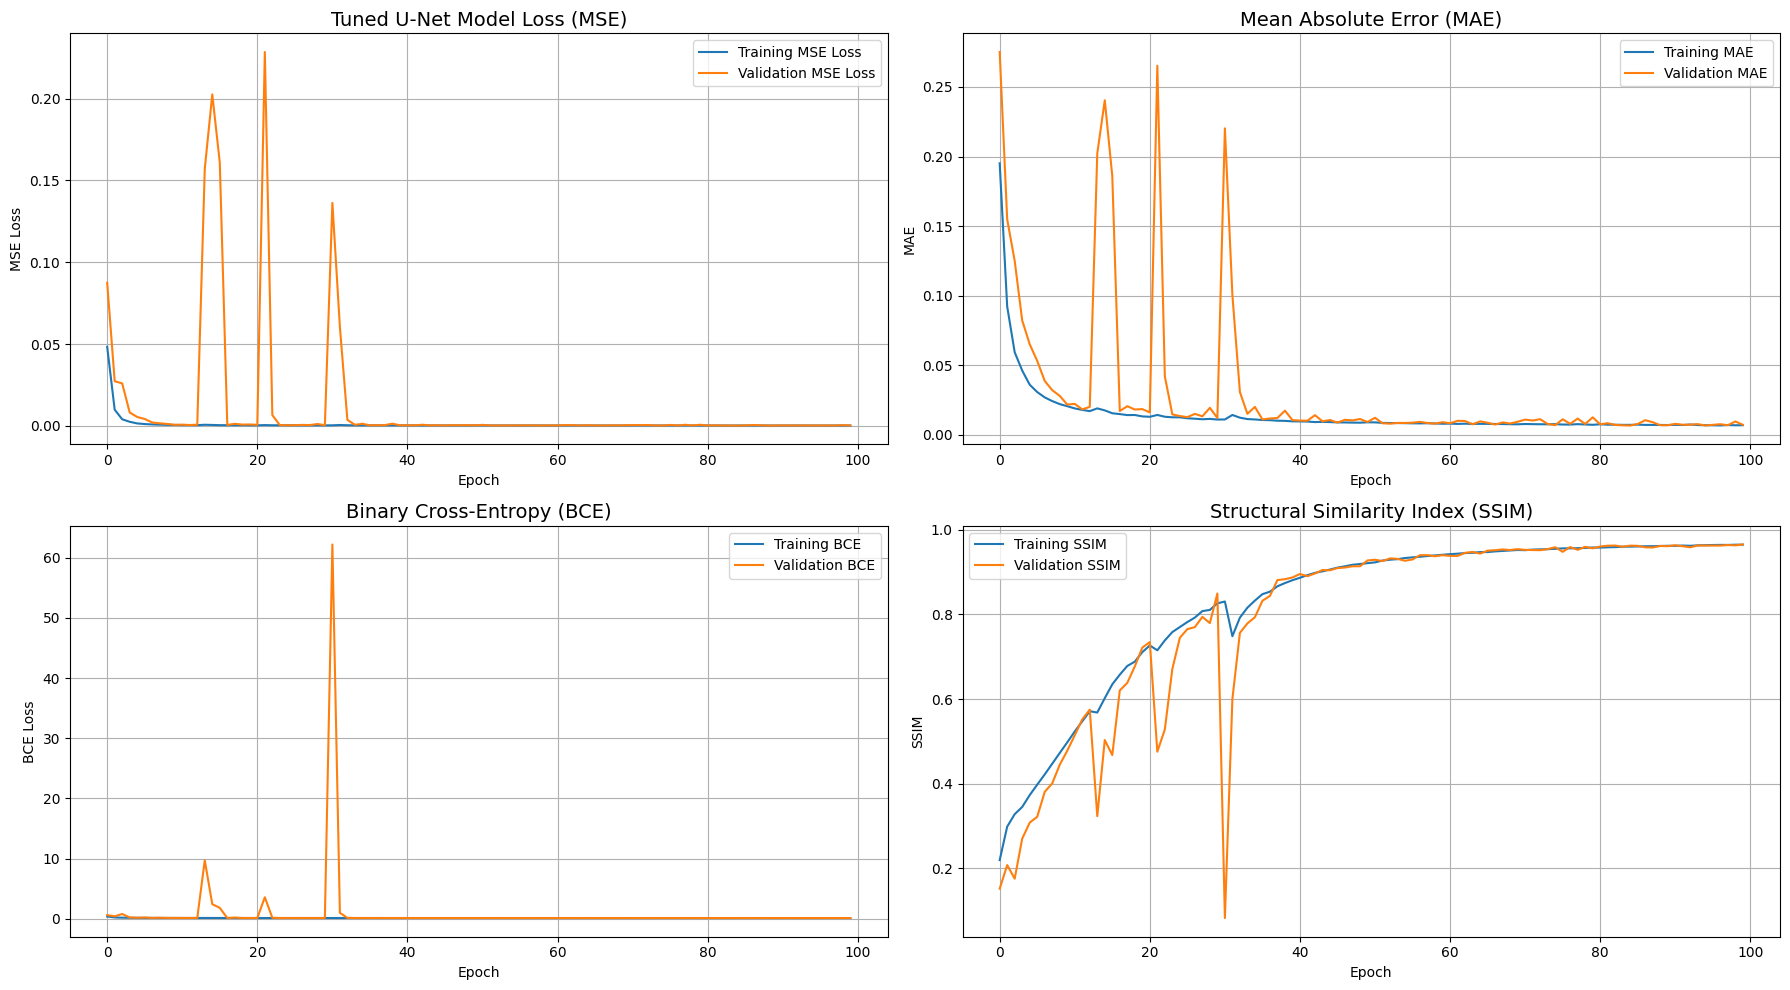

In [81]:
# Tuned U-Net Training History: MSE, MAE, BCE, SSIM
plt.figure(figsize=(18, 10))

# MSE Loss
plt.subplot(2, 2, 1)
plt.plot(history3.history.get('loss'), label='Training MSE Loss')
plt.plot(history3.history.get('val_loss'), label='Validation MSE Loss')
plt.title('Tuned U-Net Model Loss (MSE)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# MAE
if 'mae' in history3.history:
    plt.subplot(2, 2, 2)
    plt.plot(history3.history['mae'], label='Training MAE')
    plt.plot(history3.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error (MAE)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

# Binary Cross-Entropy
if 'binary_crossentropy' in history3.history:
    plt.subplot(2, 2, 3)
    plt.plot(history3.history['binary_crossentropy'], label='Training BCE')
    plt.plot(history3.history['val_binary_crossentropy'], label='Validation BCE')
    plt.title('Binary Cross-Entropy (BCE)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.legend()
    plt.grid(True)

# SSIM
if 'ssim_metric' in history3.history:
    plt.subplot(2, 2, 4)
    plt.plot(history3.history['ssim_metric'], label='Training SSIM')
    plt.plot(history3.history['val_ssim_metric'], label='Validation SSIM')
    plt.title('Structural Similarity Index (SSIM)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**1. MSE Plot:**
The training loss (blue line) drops quickly and stays low, which is good. But the validation loss (orange line) shows sudden spikes, meaning that in some training rounds, the model made big mistakes on new images it hadn’t seen before.
<br>
<br>
**2. MAE Plot:**
This plot looks similar to MSE. Training error stays low, but the validation error also has sharp jumps at certain points, showing that the model sometimes struggles to predict accurate pixel values for the test images.
<br>
<br>
**3. BCE Plot:**
The training line stays low and steady, but the validation line shows very high spikes. This means that sometimes, the model did poorly when predicting pixel values in a way that aligns with how binary data should behave, indicating high instability at those times.
<br>
<br>
**4. SSIM Plot:**
SSIM measures how close the denoised image is to the real one in structure. The training score improves and stays high. The validation score also improves, but it dips sharply during the same times the loss spikes happen, meaning the image quality dropped during those moments.

We used the **same U-Net architecture** as before, but this time we fine-tuned it using **GridSearch**, which automatically tested 8 different combinations of settings to find the best one. It tried different **activation functions** (`relu`, `elu`), **starting filter sizes** (`64`, `128`), and **learning rates** (`0.001`, `0.0001`). The goal was to pick the combination that gave the **lowest validation loss**.

In the end, the best result came from using:

* **Activation**: `relu`
* **filters\_c1**: `64`
* **Learning rate**: `0.001`

This tuned model performed better overall, but the training plots show that even though it learned well (with low training loss), the **validation loss had big spikes**. This means that while the model usually works well on unseen data, there were moments during training when it made **larger mistakes**. These jumps may be due to sensitivity in the training process, even with good hyperparameters. But overall, thanks to GridSearch, we got a model that produces **very clean results**, with strong SSIM and low errors.



In [82]:
print("\nEvaluating Tuned U-Net model on the TEST SET...")
results3 = modelTuned.evaluate(x_test_noisy, x_test, batch_size=16, verbose=1)

test_mse3   = results3[0]  # loss
test_ssim3  = results3[1]
test_mae3   = results3[2]
test_bce3   = results3[3]

print(f"Final Test Loss (MSE):         {test_mse3:.6f}")
print(f"Final Test SSIM:               {test_ssim3:.6f}")
print(f"Final Test MAE:                {test_mae3:.6f}")
print(f"Final Test Binary CrossEntropy:{test_bce3:.6f}")


Evaluating Tuned U-Net model on the TEST SET...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - binary_crossentropy: 0.1127 - loss: 2.3118e-04 - mae: 0.0065 - ssim_metric: 0.9629
Final Test Loss (MSE):         0.000230
Final Test SSIM:               0.962788
Final Test MAE:                0.006506
Final Test Binary CrossEntropy:0.113496


* **MSE: 0.000230**: The reconstruction error is **very low**, indicating the model denoises images with excellent precision. This means on average, the squared pixel error is just \~0.023%, a significant improvement.

* **SSIM: 0.9628**: The structural similarity remains **outstanding**. A score near 0.96 means the model preserves the visual features and layout of the clean images very well.

* **MAE: 0.0065**: The average absolute difference between predicted and actual pixel values is **less than 1%**, showing a high level of consistency and accuracy in pixel-wise reconstruction.

* **Binary Cross-Entropy: 0.1135**: This low BCE score reflects how well the model maintains the overall pixel intensity distribution, crucial for detailed texture and tone accuracy.

---

**What this all means:**

The **Tuned U-Net** model delivers **excellent performance** on the denoising task. It improves upon the base U-Net by achieving a **lower MSE and MAE**, meaning fewer mistakes and finer pixel-level accuracy. The **strong SSIM** score confirms that the model preserves image structure and clarity, while the **low BCE** highlights its ability to maintain realistic pixel distributions. Overall, this version shows the **most refined and reliable performance** of all models tested.

In [84]:
from skimage.metrics import structural_similarity as ssim
model_name = "Tuned U-Net"
reconstructed_images3 = modelTuned.predict(x_test_noisy)

ssim_scores_tuned = []
for denoised, original in zip(reconstructed_images3, x_test):
    score = ssim(original, denoised, data_range=1.0, channel_axis=-1)
    ssim_scores_tuned.append(score)

ssim_scores_tuned = np.array(ssim_scores_tuned)

# Print stats
print("Tuned U-Net SSIM Evaluation")
print("----------------------------")
print("Mean SSIM:", np.mean(ssim_scores_tuned))
print("Max SSIM:", np.max(ssim_scores_tuned))
print("Min SSIM:", np.min(ssim_scores_tuned))
print("Index with highest SSIM:", np.argmax(ssim_scores_tuned))
print("Index with lowest SSIM:", np.argmin(ssim_scores_tuned))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Tuned U-Net SSIM Evaluation
----------------------------
Mean SSIM: 0.9645795
Max SSIM: 0.97910064
Min SSIM: 0.93935305
Index with highest SSIM: 28
Index with lowest SSIM: 95


The Tuned U-Net model shows a **consistently high SSIM**, with an average score of **0.9646**, meaning the denoised images are very similar in structure to the clean ones. The **highest SSIM of 0.9791** (at index 28) indicates near-perfect reconstruction for that image, while the **lowest score of 0.9394** (at index 95) is still strong, showing that even the worst-case output is still visually close to the original. Overall, this means the model performs **very well and consistently** across different test images.

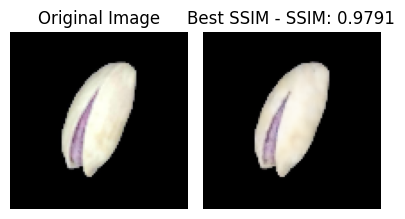

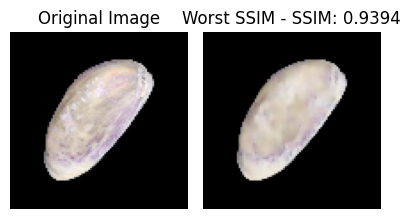

In [85]:
for idx, label in zip([np.argmax(ssim_scores_tuned), np.argmin(ssim_scores_tuned)], ["Best SSIM", "Worst SSIM"]):
    plt.figure(figsize=(4, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx])
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_images3[idx])
    plt.title(f"{label} - SSIM: {ssim_scores_tuned[idx]:.4f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## ***Prediction***

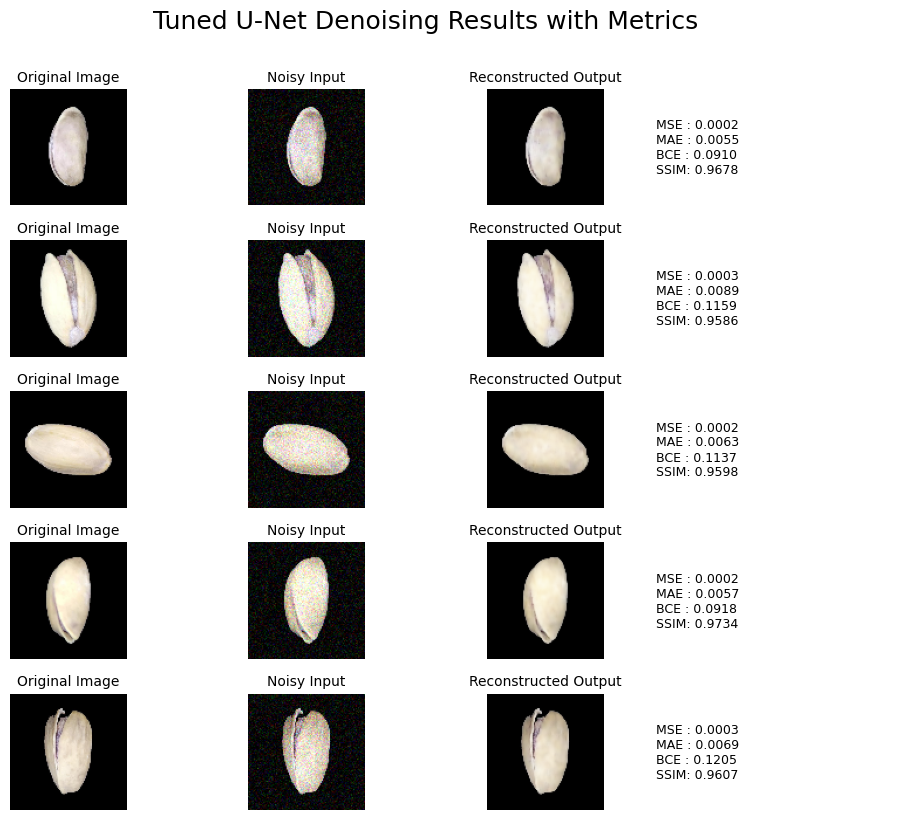

In [86]:
num_images_to_show = min(5, len(x_test))

fig, axes = plt.subplots(num_images_to_show, 4, figsize=(10, 8))
fig.suptitle(f'{model_name} Denoising Results with Metrics', fontsize=18, y=1.02)

titles = ['Original Image', 'Noisy Input', 'Reconstructed Output']

for i in range(num_images_to_show):
    orig = x_test[i]
    noisy = x_test_noisy[i]
    recon = reconstructed_images3[i]

    images = [orig, noisy, recon]
    for j in range(3):
        axes[i, j].imshow(images[j])
        axes[i, j].set_title(titles[j], fontsize=10)
        axes[i, j].axis('off')

    orig_flat = orig.flatten()
    recon_flat = recon.flatten()

    mse = mean_squared_error(orig_flat, recon_flat)
    mae = mean_absolute_error(orig_flat, recon_flat)
    bce = tf.keras.losses.binary_crossentropy(orig, recon).numpy().mean()
    ssim = tf.image.ssim(tf.convert_to_tensor(orig), tf.convert_to_tensor(recon), max_val=1.0).numpy().mean()

    axes[i, 3].axis('off')
    metrics_text = (
        f"MSE : {mse:.4f}\n"
        f"MAE : {mae:.4f}\n"
        f"BCE : {bce:.4f}\n"
        f"SSIM: {ssim:.4f}"
    )
    axes[i, 3].text(0, 0.5, metrics_text, fontsize=9, va='center')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# **Comparison**

In [90]:
print("\n📊 Final Test Set Evaluation Summary")
print("=" * 65)
print(f"{'Model':<20} | {'MSE Loss':^8} | {'SSIM':^8} | {'MAE':^8} | {'BCE':^10}")
print("-" * 65)
print(f"{'Baseline':<20} | {test_mse:.6f} | {test_ssim:.6f} | {test_mae:.6f} | {test_bce:.6f}")
print(f"{'U-Net':<20} | {test_mse2:.6f} | {test_ssim2:.6f} | {test_mae2:.6f} | {test_bce2:.6f}")
print(f"{'Tuned U-Net':<20} | {test_mse3:.6f} | {test_ssim3:.6f} | {test_mae3:.6f} | {test_bce3:.6f}")
print("=" * 65)


📊 Final Test Set Evaluation Summary
Model                | MSE Loss |   SSIM   |   MAE    |    BCE    
-----------------------------------------------------------------
Baseline             | 0.000584 | 0.956589 | 0.007970 | 0.114504
U-Net                | 0.000408 | 0.965681 | 0.008883 | 0.115057
Tuned U-Net          | 0.000230 | 0.962788 | 0.006506 | 0.113496


* **Baseline Autoencoder**: Performs reasonably well, with moderate MSE and SSIM. It learns to denoise effectively, but less accurately than the more complex models.

* **U-Net**: Shows **highest SSIM**, meaning it preserves the overall **visual structure** best. However, it has slightly **higher error values** (MSE, MAE) compared to the tuned model.

* **Tuned U-Net**: Delivers the **best overall numerical performance** — lowest **MSE**, **MAE**, and **BCE**, meaning it reconstructs pixel values with **greater precision** and generalizes well. While its SSIM is slightly lower than plain U-Net, it still indicates **very high visual quality**.


# **Conclusion**

The **Tuned U-Net** is the most optimized model, offering **the best balance between precision and consistency**, thanks to GridSearch-tuned hyperparameters. It outperforms both the baseline and standard U-Net in most evaluation metrics.
